# MAG analysis notebook

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from MAG import MicrosoftAcademicGraph
import os
from sparkhpc import sparkjob
import findspark
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd

import MAGspark 
from MAG_network import CitationNetwork

plt.style.use('ggplot')

# set environment variables
os.environ["SPARK_LOCAL_DIRS"] = "/home/laal/MAG/TMP"
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-1.8.0-openjdk-1.8.0.242.b08-0.el7_7.x86_64"
os.environ['SPARK_HOME'] = "/home/laal/MAG/spark-3.0.2-bin-hadoop2.7"

In [2]:
mag, spark = MAGspark.get_mag_with_cluster_connection(jobid=39924, memory_per_executor=14000,
                                                      data_folderpath="/home/laal/MAG/DATA/")

['NAME STATE JOBID', 'seed1.6 PENDING 39908', 'seed1.7 PENDING 39909', 'hadi-gpu-job RUNNING 39883', 'hyperopt RUNNING 39676', 'sparkcluster RUNNING 39924', 'hyperopt RUNNING 39677', 'seed1.5 RUNNING 39907', 'hyperopt RUNNING 39678', 'resume7_ccmfotw_roberta_base_fp16_1M RUNNING 39849', 'train-network2 RUNNING 39910', 'resume6_cc13_roberta_base_fp16_1M RUNNING 39850', 'jupyter RUNNING 39925', 'jupyter RUNNING 39845', 'seed1.4 RUNNING 39906', 'seed1.3 RUNNING 39905', 'seed1.2 RUNNING 39904', 'resume8_ccs_roberta_base_fp16_1M RUNNING 39848', 'seed1.1 RUNNING 39903', 'seed1.0 RUNNING 39902', 'headhpose_kfold RUNNING 39920', 'headhpose_kfold RUNNING 39919', '']


In [90]:
spark.stop()

Load Field of Study level 0 into pandas dataframe

In [3]:
fos_df = pd.read_csv('MAG_FILES/field_of_study.csv')
# extract level 0
fos_df = fos_df.query("Level == 0")

In [4]:
def paper_field_of_study(mag):
    """
    Counts the number of unique papers in the MAG graph with a
    level-0 field of study.
    """
    
    fos = mag.getDataframe('FieldsOfStudy')
    paper_fos = mag.getDataframe('PaperFieldsOfStudy')
    
    query = """
        SELECT 
        COUNT(DISTINCT(CASE WHEN fs.Level = 0 THEN pfs.PaperId ELSE null END)) as CountL0,
        COUNT(DISTINCT(pfs.PaperId)) as CountPapers
        FROM PaperFieldsOfStudy pfs
        LEFT JOIN FieldsOfStudy fs ON pfs.FieldOfStudyId = fs.FieldOfStudyId
    """
    
    # execute query and convert to pandas dataframe
    paperfos = mag.query_sql(query)
    paperfos_df = paperfos.toPandas()
    
    # report paper counts
    count_level0 = paper_fos_level_0_df.iloc[0]['CountL0']
    count_all    =  paper_fos_level_0_df.iloc[0]['CountPapers']
    print("{} / {} = {} % of papers have no level-0 discipline assigned. "
         .format(count_level0, count_all, (count_all-count_level0) / count_all))

In [4]:
def yearly_authorships_per_gender_and_discipline(mag, return_pandas=True):
    """
    Computes the yearly number of authorships per gender and discipline.
    Unknown genders are assigned the value -1. 
    """
    
    author_affiliations = mag.getDataframe('PaperAuthorAffiliations')
    paper_root_field = mag.getDataframe('PaperRootFieldMag')
    papers = mag.getDataframe('Papers')
    authors = mag.getDataframe('WosToMag')
    
    query = """
    SELECT 
    YEAR(p.Date) as Year, 
    prf.FieldOfStudyId, 
    CASE WHEN wtm.Gender in (0, 1) THEN wtm.Gender ELSE -1 END as Gender, 
    COUNT(paa.PaperId) as Authorships,
    COUNT(DISTINCT(paa.PaperId)) as DistinctPapers
    FROM PaperAuthorAffiliations paa
    LEFT JOIN WosToMag wtm ON paa.AuthorId = wtm.MAG
    INNER JOIN Papers p ON paa.PaperId = p.PaperId
    INNER JOIN PaperRootFieldMag prf ON paa.PaperId = prf.PaperId
    GROUP BY YEAR(p.Date), CASE WHEN wtm.Gender in (0, 1) THEN wtm.Gender ELSE -1 END, prf.FieldOfStudyId
    """
    gender_per_discipline = mag.query_sql(query)
    
    if return_pandas: 
        return gender_per_discipline.toPandas()
    else:
        return gender_per_discipline

In [5]:
authorships = yearly_authorships_per_gender_and_discipline(mag, return_pandas=True)

In [7]:
gender_mapping = {
    0: 'Female',
    1: 'Male', 
    -1: 'N/A'
}
authorships['Gender '] = authorships.Gender.apply(lambda x: gender_mapping[x])

In [8]:
authorships.to_csv('MAG_FILES/AuthorshipsPerYearFieldAndGender.csv', index=False)

In [9]:
authorships_filtered = authorships.sort_values(by=['FieldOfStudyId', 'Year'])
authorships_filtered = authorships_filtered[(authorships_filtered['Year'] > 1950) & 
                                            (authorships_filtered['Year'] < 2021)]

In [10]:
def plot_authorships(authorships_df, fields=None, normalize=False, figsize=(15,50)):

    idx = 0
    
    nrows = len(fields) // 2 if fields is not None else len(fos_df) // 2 + 1
    
    fig, axs = plt.subplots(nrows=nrows, ncols=2, figsize=figsize, sharex=True)
    axs = list(axs.flatten())


    for record in fos_df.to_dict('records'):

        if fields is not None and record['FieldOfStudyId'] not in fields:
            continue
        
        filtered_data = authorships_df[authorships_df.FieldOfStudyId==record['FieldOfStudyId']]
        # filtered_data = filtered_data[filtered_data.Year > 1975]
        filtered_pivot = filtered_data.pivot(index='Year', columns='Gender ', values='Authorships')
        
        # normalize by total number of authorships 
        if normalize:
            filtered_pivot['Total'] = filtered_pivot['Female'] +  filtered_pivot['Male'] +  filtered_pivot['N/A']
            filtered_pivot['Female'] = filtered_pivot['Female'] / filtered_pivot['Total']
            filtered_pivot['Male'] = filtered_pivot['Male'] / filtered_pivot['Total']
            filtered_pivot['N/A'] = filtered_pivot['N/A'] / filtered_pivot['Total']
            
            del filtered_pivot['Total']


        ax = filtered_pivot.plot.area(stacked=True, ax=axs[idx], alpha=0.8, linewidth=0)
        
        colors = ["#6fc9f2", "#bd8aff", "#b8b8b8"]
        
        for index, collection in enumerate(ax.collections):
            collection.set_facecolor(colors[index])
        
        axs[idx].set_title(record['DisplayName'])
        axs[idx].set_ylabel('Authorships {}'.format('normalized' if normalize else ""))
        
        axs[idx].legend(loc='upper left')

        axs[idx].axvline(2010, color='black', ls='--', alpha=0.3)
        axs[idx].set_xlim((1951, 2020))
        
        if normalize:
            axs[idx].set_ylim((0, 1.0))
        
        idx += 1

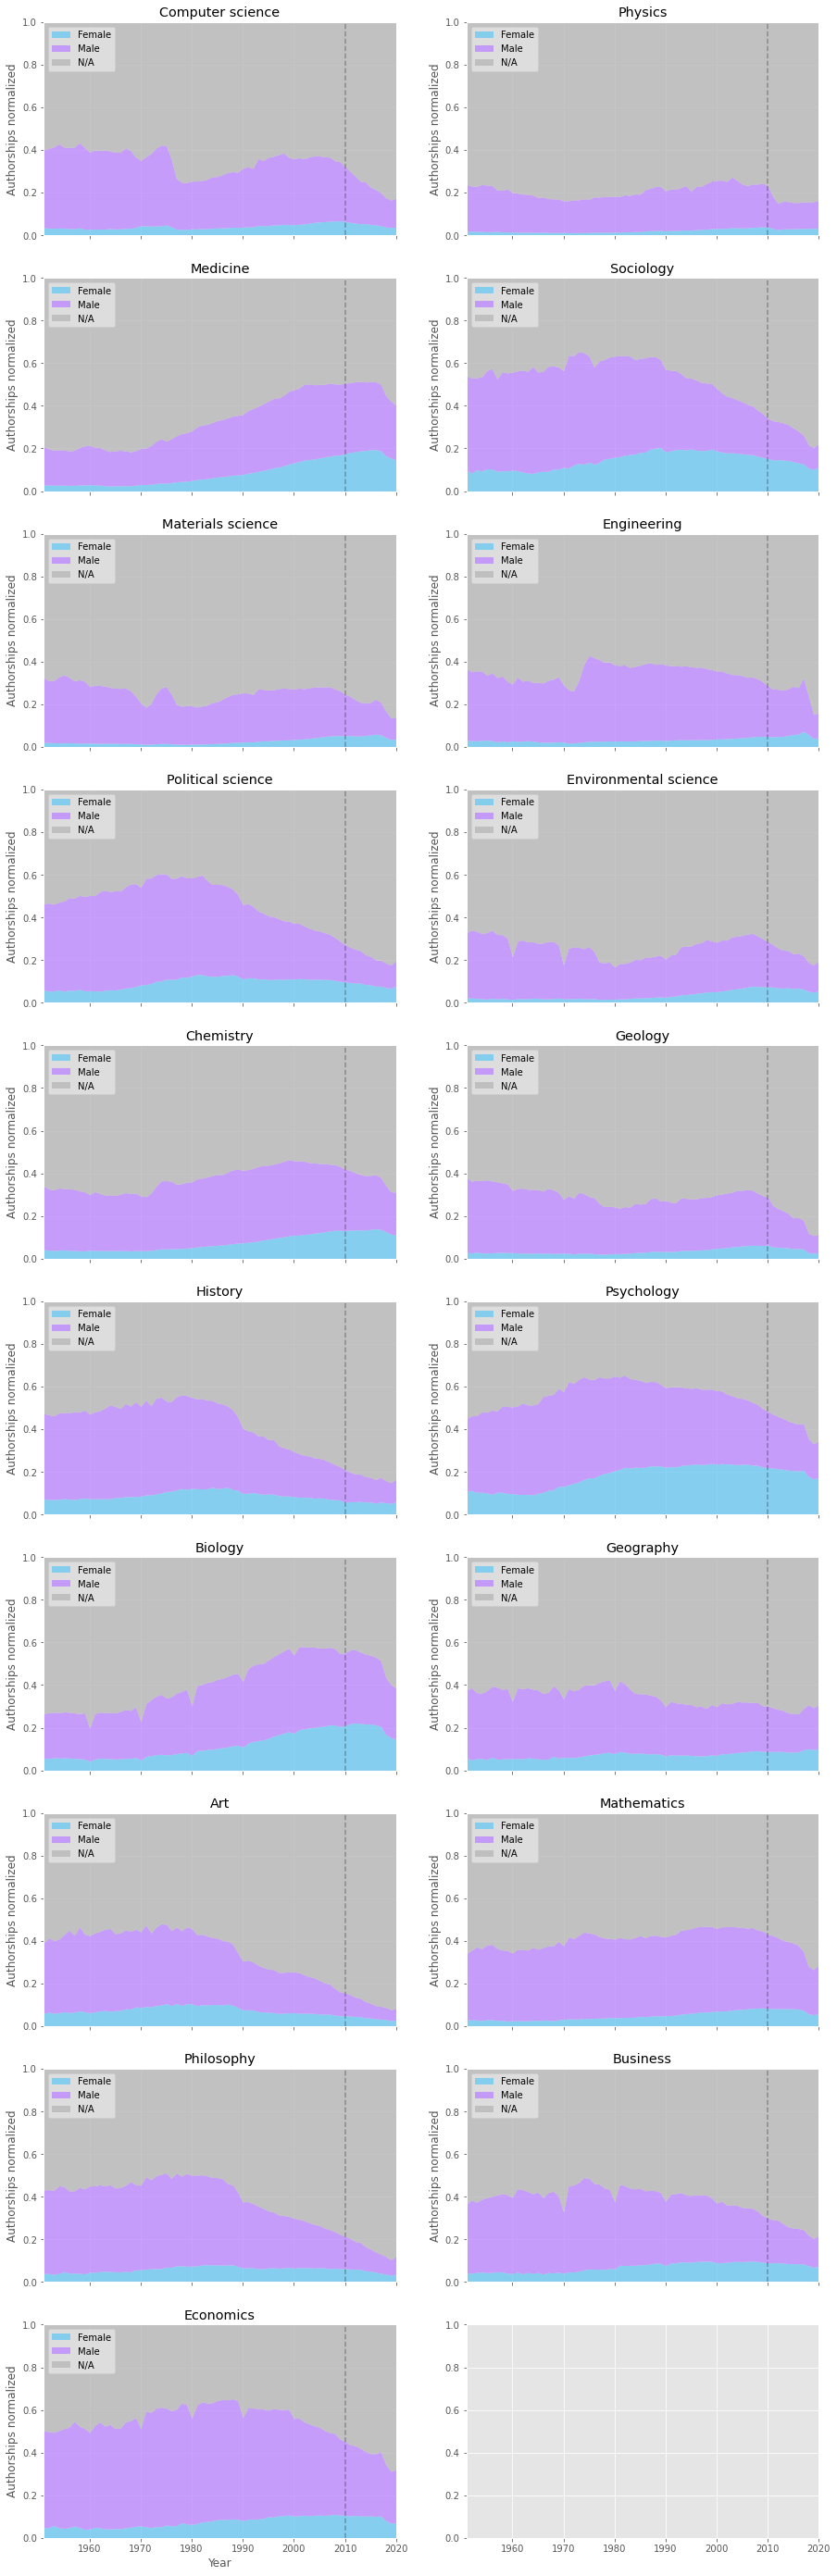

In [11]:
plot_authorships(authorships_filtered, normalize=True)

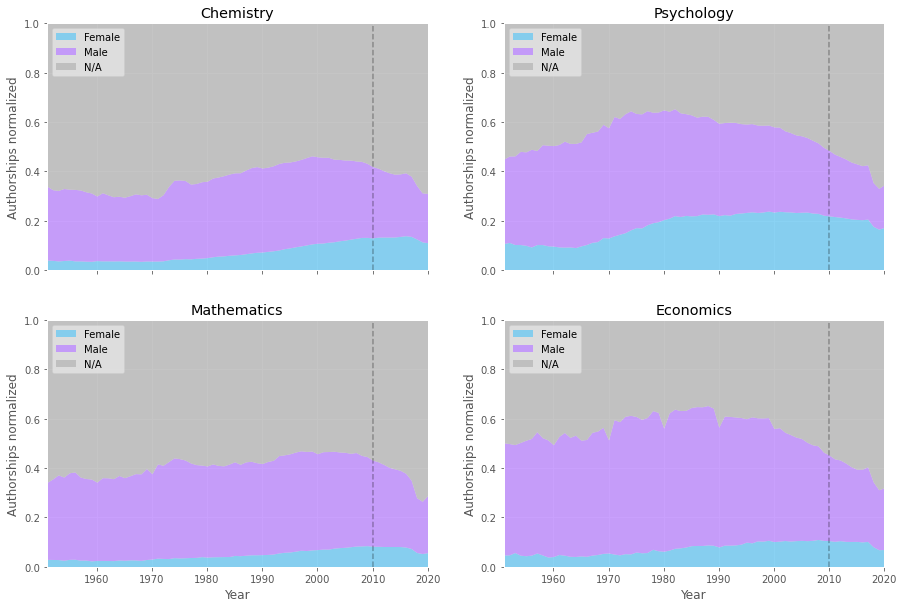

In [12]:
plot_authorships(authorships_filtered, normalize=True, fields=[185592680, 15744967, 33923547, 162324750],
                 figsize=(15,10))

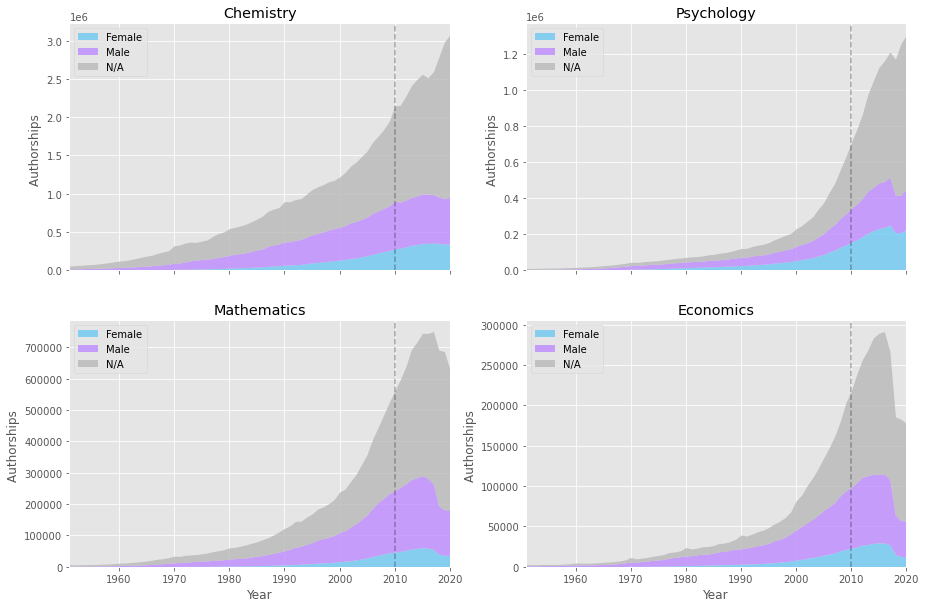

In [13]:
plot_authorships(authorships_filtered, normalize=False, 
                 fields=[185592680, 15744967, 33923547, 162324750],
                 figsize=(15,10))

## Yearly citations per gender 

In [19]:
def citations_per_gender(mag, out=False):
    """
    
    """
    econ = CitationNetwork(mag, fos_id=162324750, fos_name="Economics", root_data_folder="/home/laal/MAG/DATA")
    chem = CitationNetwork(mag, fos_id=185592680, fos_name="Chemistry", root_data_folder="/home/laal/MAG/DATA")
    psych = CitationNetwork(mag, fos_id=15744967, fos_name="Psychology", root_data_folder="/home/laal/MAG/DATA")
    math = CitationNetwork(mag, fos_id=33923547, fos_name="Mathematics", root_data_folder="/home/laal/MAG/DATA")
    
    
    papers = mag.getDataframe('Papers')
    
    network_names = ["CitationsEconomics", "CitationsChemistry", 
                     "CitationsPsychology", "CitationsMathematics"]
    
    records = pd.DataFrame()
    
    for network, name in zip([econ, chem, psych, math], network_names):
        
        citations_df = mag.getDataframe(name)
        
        query = """
            SELECT 
            '{}' as fieldName,  
            Year(p1.Date) as citingYear, 
            Year(p2.Date) as citedYear,
            n.CitingAuthorGender, 
            n.CitedAuthorGender,
            COUNT(*) as CitationCount, 
            COUNT(DISTINCT(n.CitingPaperId)) as NumCitingPapers,
            COUNT(DISTINCT(n.CitedPaperId)) as NumCitedPapers,
            COUNT(DISTINCT(n.CitingAuthorId)) as NumCitingAuthors,
            COUNT(DISTINCT(n.CitedAuthorId)) as NumCitedAuthors
            FROM {} n
            INNER JOIN Papers p1 ON n.CitingPaperId = p1.PaperId
            INNER JOIN Papers p2 ON n.CitedPaperId = p2.PaperId
            GROUP BY
                Year(p1.Date), 
                Year(p2.Date),
                n.CitingAuthorGender, 
                n.CitedAuthorGender
        """.format(network.fos_name, name)
        
        print("Starting: {} - {}".format(network.fos_name, name))
        
        result = mag.query_sql(query).toPandas()
        records = pd.concat([records, result])

    return records

In [20]:
citation_statistics = citations_per_gender(mag)

Starting: Economics - CitationsEconomics
Starting: Chemistry - CitationsChemistry
Starting: Psychology - CitationsPsychology
Starting: Mathematics - CitationsMathematics


In [22]:
citation_statistics.to_csv("MAG_FILES/GenderedCitationsPerYear.csv", index=False)

In [33]:
citation_statistics.query("fieldName == 'Economics'")

,fieldName,citingYear,citedYear,CitingAuthorGender,CitedAuthorGender,CitationCount,NumCitingPapers,NumCitedPapers,NumCitingAuthors,NumCitedAuthors
0,Economics,2005.0,2005.0,0,-1,1800,809,764,837,815
1,Economics,2008.0,1982.0,1,1,10435,3482,989,4535,1142
2,Economics,2012.0,2008.0,-1,1,57940,12930,10016,15942,11955
3,Economics,1997.0,1993.0,-1,0,794,454,341,526,328
4,Economics,2001.0,2000.0,0,1,5977,1573,2030,1508,2589
...,...,...,...,...,...,...,...,...,...,...
51264,Economics,1997.0,1888.0,1,1,1,1,1,1,1
51265,Economics,1977.0,1944.0,0,1,1,1,1,1,1
51266,Economics,1953.0,1936.0,1,-1,1,1,1,1,1
51267,Economics,2013.0,1935.0,1,0,1,1,1,1,1


In [35]:
gender_mapping = {
    0: 'Female',
    1: 'Male', 
    -1: 'N/A'
}
citation_statistics['CitingAuthorGender'] = citation_statistics.CitingAuthorGender.apply(lambda x: gender_mapping[x])
citation_statistics['CitedAuthorGender'] = citation_statistics.CitedAuthorGender.apply(lambda x: gender_mapping[x])

In [66]:
def plot_citations(citations_df, fields=None, normalize=False, figsize=(15,50), out=False,
                   suptitle=None):

    idx = 0
    
    nrows = len(fields) // 2 if fields is not None else len(fos_df) // 2 + 1
    
    fig, axs = plt.subplots(nrows=nrows, ncols=2, figsize=figsize, sharex=True)
    axs = list(axs.flatten())

    for record in fos_df.to_dict('records'):

        if fields is not None and record['FieldOfStudyId'] not in fields:
            continue
        
        if out:
            filtered_data = citations_df.query("fieldName == '{}'".format(record['DisplayName']))
            filtered_data = filtered_data.groupby(['citingYear', 'CitingAuthorGender'])['CitationCount'].sum().reset_index()
            filtered_pivot = filtered_data.pivot(index='citingYear', columns='CitingAuthorGender', values='CitationCount')
        else:
            filtered_data = citations_df.query("fieldName == '{}'".format(record['DisplayName']))
            filtered_data = filtered_data.groupby(['citedYear', 'CitedAuthorGender'])['CitationCount'].sum().reset_index()
            filtered_pivot = filtered_data.pivot(index='citedYear', columns='CitedAuthorGender', values='CitationCount')    
        
        # filtered_data = filtered_data[filtered_data.Year > 1975]
        
        
        # normalize by total number of authorships 
        if normalize:
            filtered_pivot['Total'] = filtered_pivot['Female'] +  filtered_pivot['Male'] +  filtered_pivot['N/A']
            filtered_pivot['Female'] = filtered_pivot['Female'] / filtered_pivot['Total']
            filtered_pivot['Male'] = filtered_pivot['Male'] / filtered_pivot['Total']
            filtered_pivot['N/A'] = filtered_pivot['N/A'] / filtered_pivot['Total']
            
            del filtered_pivot['Total']


        ax = filtered_pivot.plot.area(stacked=True, ax=axs[idx], alpha=0.8, linewidth=0)
        
        colors = ["#6fc9f2", "#bd8aff", "#b8b8b8"]
        
        for index, collection in enumerate(ax.collections):
            collection.set_facecolor(colors[index])
        
        axs[idx].set_title(record['DisplayName'])
        axs[idx].set_ylabel('Citations between authors {}'.format('\nnormalized' if normalize else ""))
        
        axs[idx].legend(loc='upper left')

        axs[idx].axvline(2010, color='black', ls='--', alpha=0.3)
        axs[idx].set_xlim((1951, 2020))
        
        if normalize:
            axs[idx].set_ylim((0, 1.0))
        
        idx += 1
    plt.suptitle(suptitle, fontsize=18)
    plt.tight_layout()

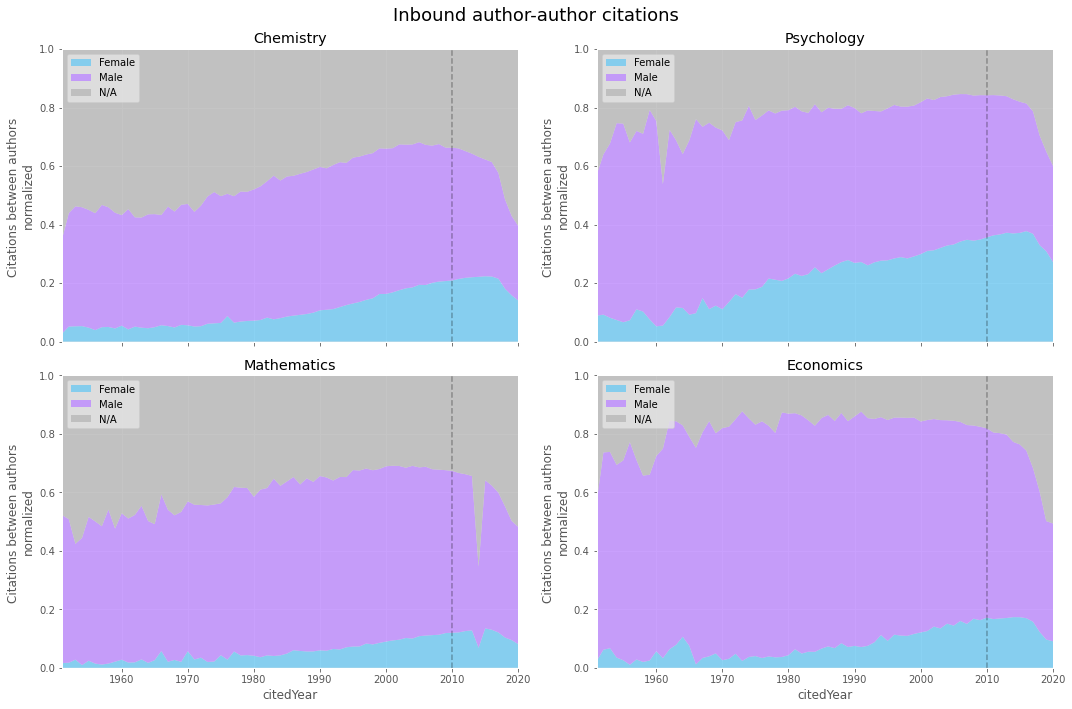

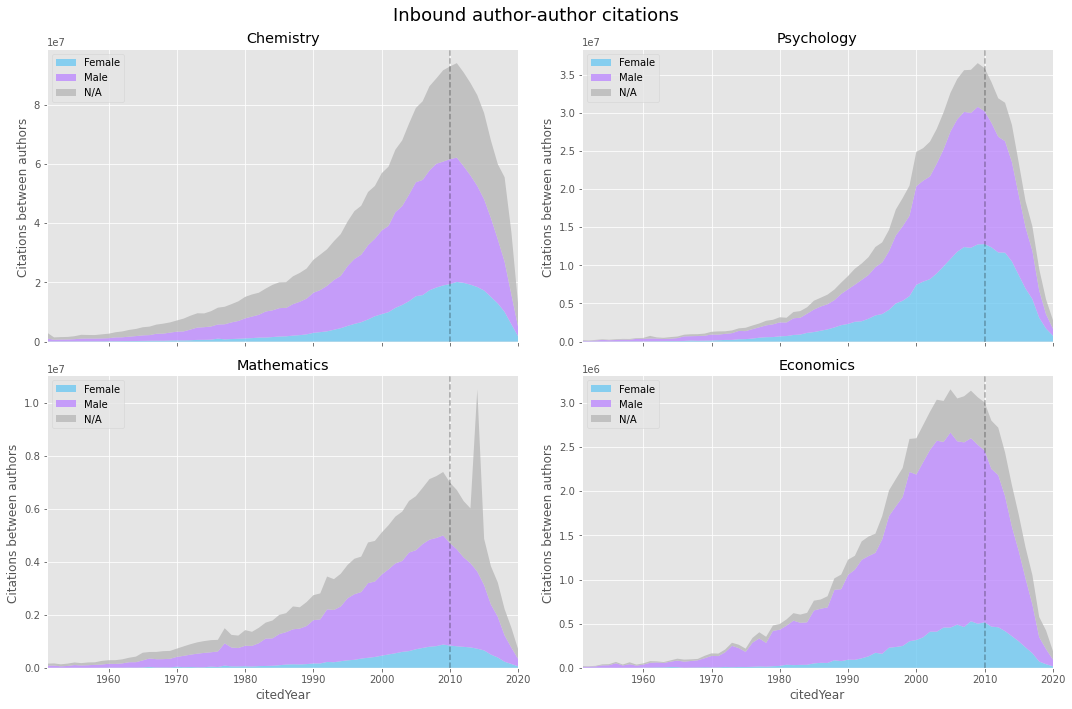

In [68]:
plot_citations(citation_statistics, normalize=True, fields=[185592680, 15744967, 33923547, 162324750],
               figsize=(15,10), out=False, suptitle="Inbound author-author citations")
plot_citations(citation_statistics, normalize=False, fields=[185592680, 15744967, 33923547, 162324750],
               figsize=(15,10), out=False, suptitle="Inbound author-author citations")

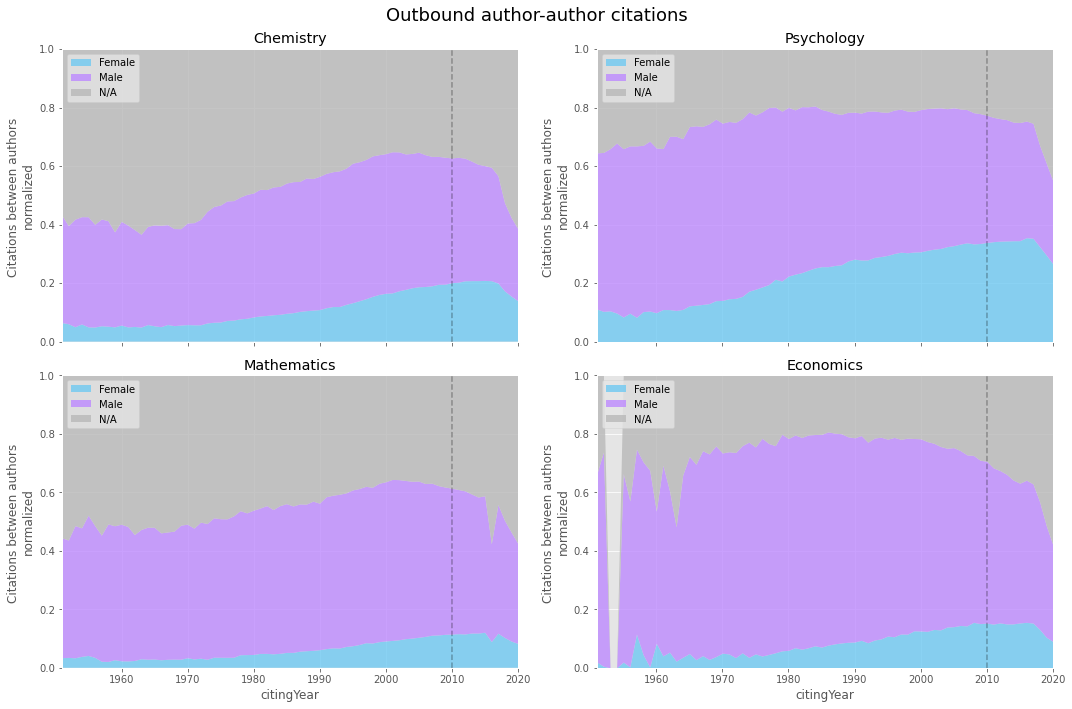

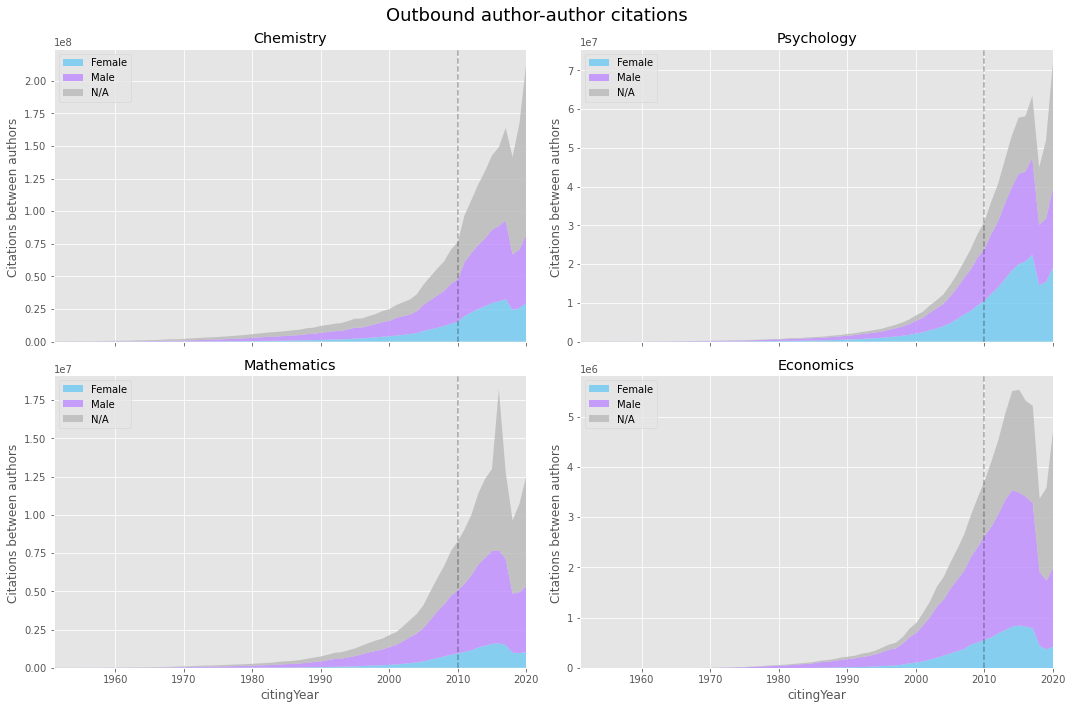

In [69]:
plot_citations(citation_statistics, normalize=True, fields=[185592680, 15744967, 33923547, 162324750],
               figsize=(15,10), out=True, suptitle="Outbound author-author citations")
plot_citations(citation_statistics, normalize=False, fields=[185592680, 15744967, 33923547, 162324750],
               figsize=(15,10), out=True, suptitle="Outbound author-author citations")

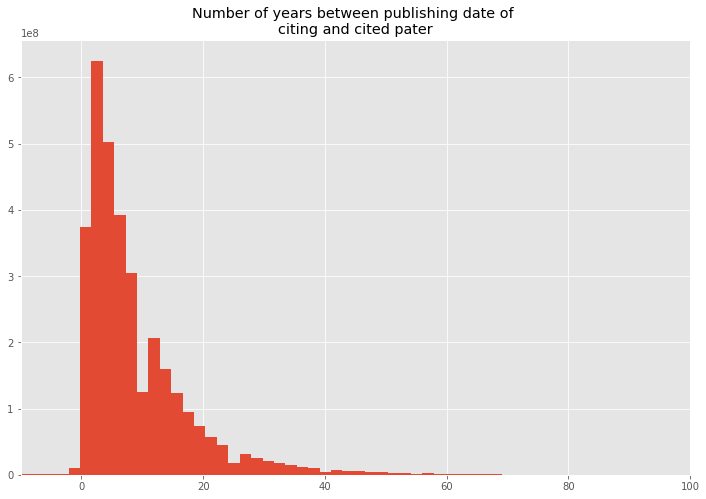

In [97]:
citation_statistics['yearDiff'] = citation_statistics['citingYear'] - citation_statistics['citedYear']
#citation_statistics['yearDiff'].plot(kind='hist', figsize=(12, 8), bins=100, 
#                                     weights=citation_statistics['CitationCount'])

plt.figure(figsize=(12,8))

def plot_year_diff(citation_statistics):
    citation_statistics['yearDiff'] = citation_statistics['citingYear'] - citation_statistics['citedYear']

    fig, axs = plt.subplots(nrows=nrows, ncols=2, figsize=figsize, sharex=True)
    axs = list(axs.flatten())
    
    idx = 0
    
    for name in citation_statistics.fieldName.unique():
        
        filtered = 
        
    

x = plt.hist(citation_statistics['yearDiff'].values, bins=200, weights=citation_statistics['CitationCount'].values,
         log=False)
plt.xlim((-10, 100))
plt.title('Number of years between publishing date of \nciting and cited pater')
plt.show()

In [89]:
citation_statistics['yearDiff'].describe()

count    342755.00000
mean         42.56185
std          50.23049
min        -154.00000
25%           8.00000
50%          35.00000
75%          73.00000
max         221.00000
Name: yearDiff, dtype: float64

In [79]:
citation_statistics['yearDiff'].shape

(344408,)

In [81]:
citation_statistics['CitationCount'].shape

(344408,)

In [75]:
citation_statistics.sort_values(by='yearDiff')

,fieldName,citingYear,citedYear,CitingAuthorGender,CitedAuthorGender,CitationCount,NumCitingPapers,NumCitedPapers,NumCitingAuthors,NumCitedAuthors,yearDiff
71270,Mathematics,1841.0,1995.0,Male,N/A,2,1,1,2,1,-154.0
104310,Chemistry,1870.0,2004.0,N/A,N/A,1,1,1,1,1,-134.0
39862,Mathematics,1873.0,2006.0,N/A,Male,1,1,1,1,1,-133.0
77061,Chemistry,1835.0,1967.0,Male,N/A,1,1,1,1,1,-132.0
30805,Mathematics,1878.0,2006.0,Male,Male,1,1,1,1,1,-128.0
...,...,...,...,...,...,...,...,...,...,...,...
81329,Mathematics,NaN,2000.0,N/A,Male,1,1,1,1,1,NaN
82100,Mathematics,NaN,1971.0,N/A,Male,2,1,1,2,1,NaN
83025,Mathematics,NaN,2010.0,Male,Male,2,1,1,2,1,NaN
83108,Mathematics,2013.0,NaN,N/A,N/A,1,1,1,1,1,NaN


In [41]:
filtered_pivot = citation_statistics.pivot(index='citingYear', columns='CitingAuthorGender', values='CitationCount')

ValueError: Index contains duplicate entries, cannot reshape

In [49]:
d.pivot(index='citingYear', columns='CitingAuthorGender', values='CitationCount')

CitingAuthorGender,Female,Male,N/A
citingYear,,,
1806.0,NaN,NaN,1.0
1832.0,NaN,1.0,NaN
1835.0,NaN,2.0,NaN
1838.0,NaN,NaN,2.0
1840.0,NaN,1.0,NaN
...,...,...,...
2017.0,57254607.0,93228709.0,94819928.0
2018.0,40288291.0,63571862.0,95567769.0
2019.0,42400058.0,66609179.0,124208466.0


In [ ]:
discipline_cites_filtered = discipline_cites[(discipline_cites.Year > 1950) & (discipline_cites.Year < 2021)]

In [ ]:
idx = 0
fig, axs = plt.subplots(nrows=10, ncols=2, figsize=(15,50), sharex=True)
axs = list(axs.flatten())


for record in fos_df.to_dict('records'):
    
    sns.lineplot(data=discipline_cites_filtered[discipline_cites_filtered.CitingField==record['FieldOfStudyId']], 
                 x='Year', y='NumOutgoingCitations', marker="o", label='Outgoing',
                 palette='cool', ax=axs[idx]).set_title(record['DisplayName'])
    
    sns.lineplot(data=discipline_cites_filtered[discipline_cites_filtered.CitingField==record['FieldOfStudyId']], 
                 x='Year', y='NumIncomingCitations', marker="o", label='Incoming',
                 palette='cool', ax=axs[idx]).set_title(record['DisplayName'])
    
    axs[idx].set_ylabel('Number of paper citations')
    
    idx += 1

In [27]:
authorships_per_year = gender_per_discipline_per_year_unknown_all(mag)
authorships_per_year_df = authorships_per_year.toPandas()

In [6]:
authorships_per_year = gender_per_discipline_per_year_with_unknown(mag)

In [7]:
authorships_per_year_df = authorships_per_year.toPandas()

In [10]:
gender_mapping = {
    0: 'Female',
    1: 'Male', 
    -1: 'N/A $\in$ constraint',
    -2: 'N/A $\\notin$ constraint'
}

authorships_per_year_df['Gender '] = authorships_per_year_df.Gender.apply(lambda x: gender_mapping[x])

In [29]:
filtered = authorships_per_year_df.sort_values(by=['FieldOfStudyId', 'Year'])
filtered = filtered[(filtered['Year'] > 1950) & (filtered['Year'] < 2021)]

In [30]:
plt.rcParams.update({'figure.max_open_warning': 0})

Text(0, 0.5, 'Authorships')

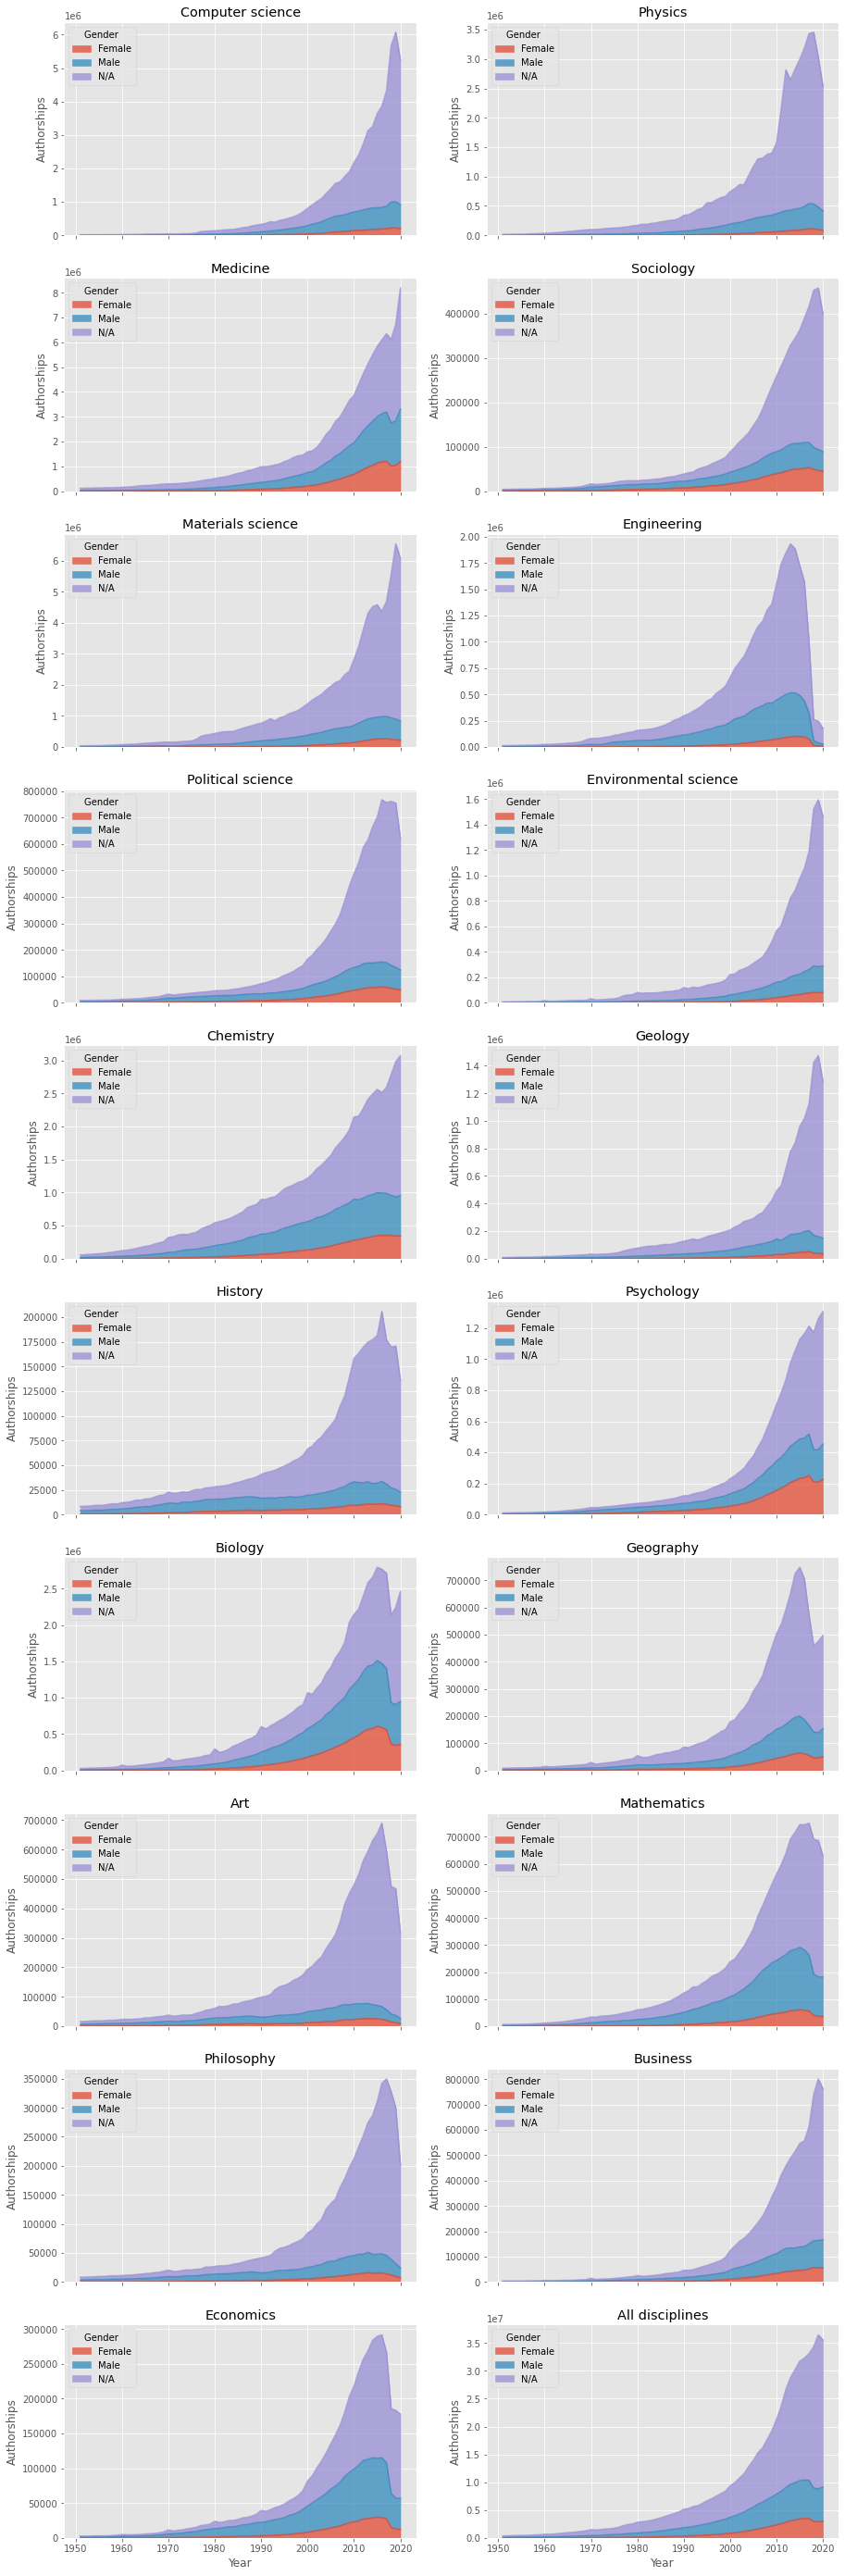

In [37]:
filtered_pivot['Total']

Year
1951.0      350653
1952.0      371782
1953.0      397676
1954.0      418806
1955.0      436031
            ...   
2016.0    32300303
2017.0    33106696
2018.0    34355267
2019.0    36477402
2020.0    35563509
Name: Total, Length: 70, dtype: int64

Text(0, 0.5, 'Authorships')

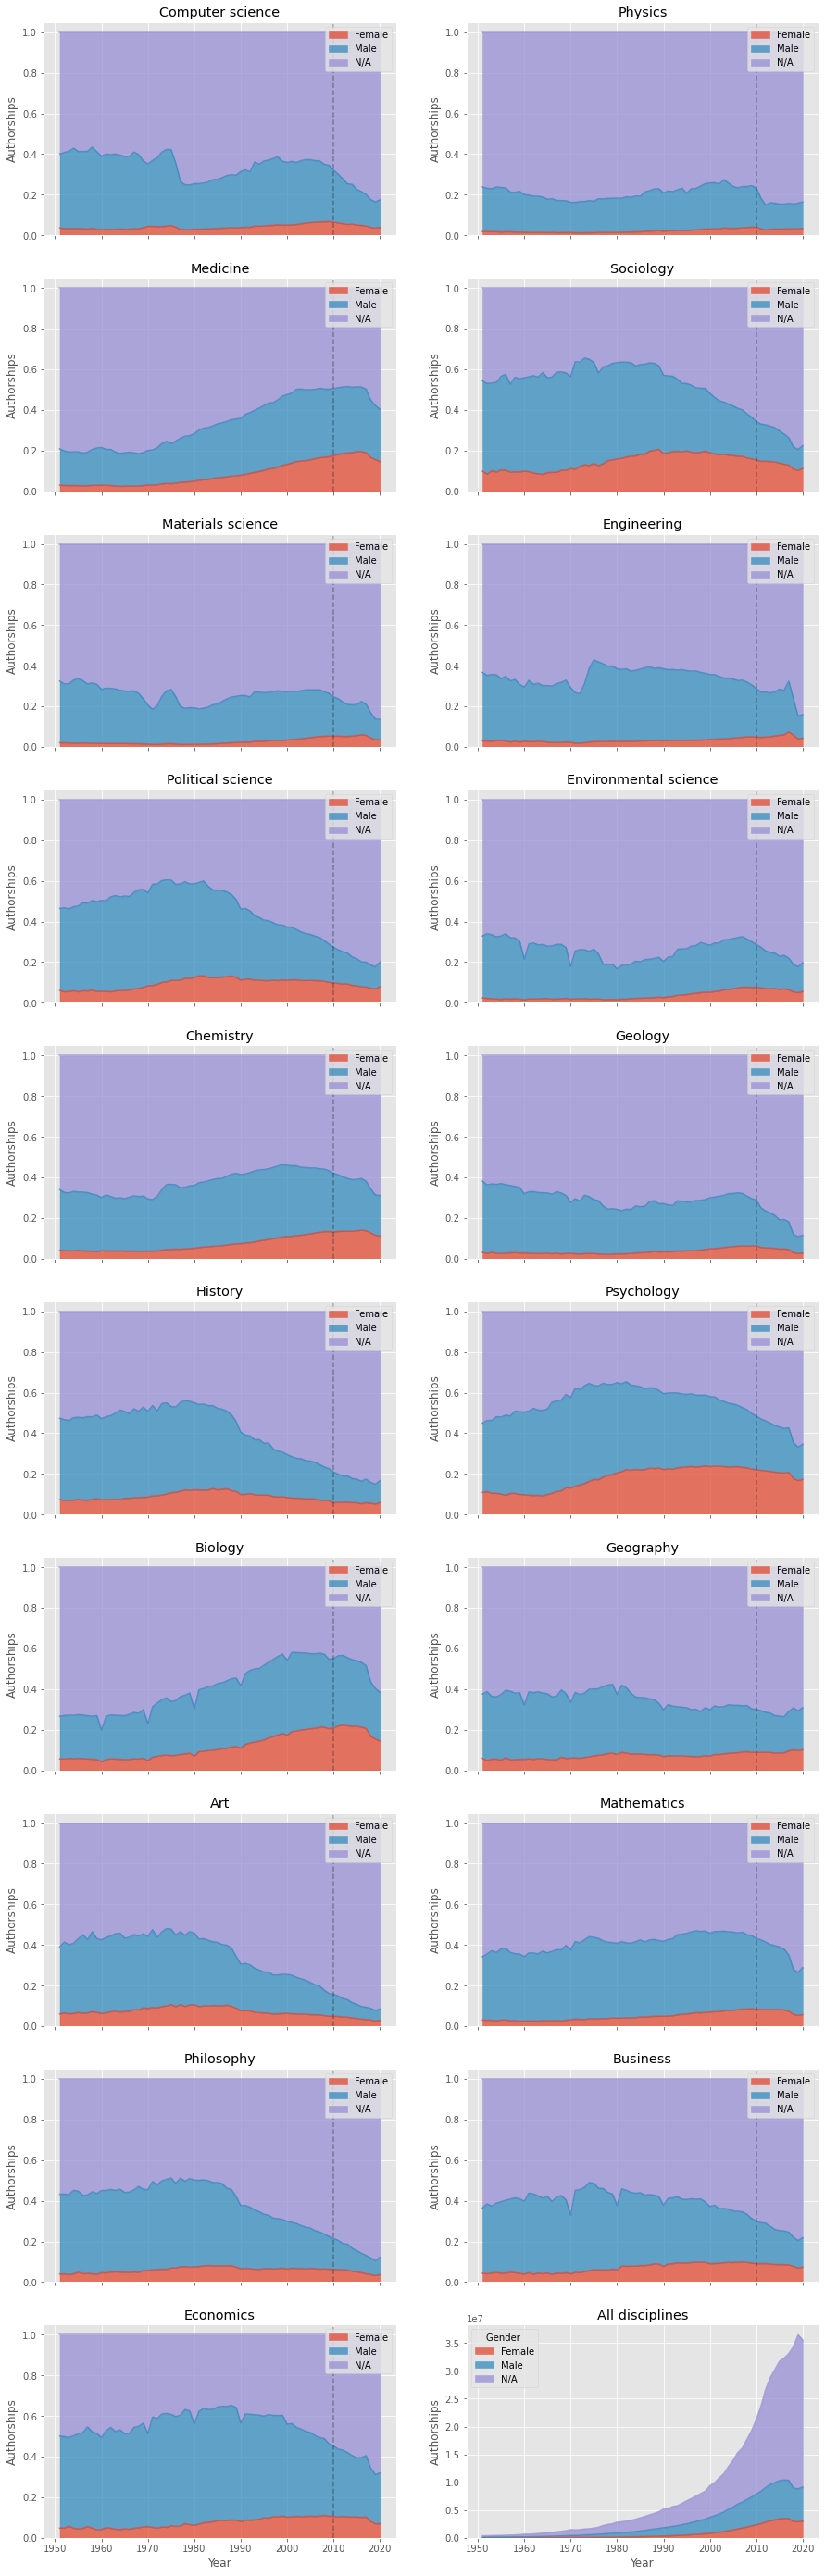

In [47]:
idx = 0
fig, axs = plt.subplots(nrows=10, ncols=2, figsize=(15,50), sharex=True)
axs = list(axs.flatten())


for record in fos_df.to_dict('records'):
    
    filtered_data = filtered[filtered.FieldOfStudyId==record['FieldOfStudyId']]
    # filtered_data = filtered_data[filtered_data.Year > 1975]
    filtered_pivot = filtered_data.pivot(index='Year', columns='Gender ', values='Authorships')
    
    filtered_pivot['Total'] = filtered_pivot['Female'] +  filtered_pivot['Male'] +  filtered_pivot['N/A']
    
    filtered_pivot['Female'] = filtered_pivot['Female'] / filtered_pivot['Total']
    filtered_pivot['Male'] = filtered_pivot['Male'] / filtered_pivot['Total']
    filtered_pivot['N/A'] = filtered_pivot['N/A'] / filtered_pivot['Total']
    
    del filtered_pivot['Total']
    
    filtered_pivot.plot.area(stacked=True, ax=axs[idx], alpha=0.75)
    axs[idx].set_title(record['DisplayName'])
    axs[idx].set_ylabel('Authorships')
    
    axs[idx].legend(loc='upper right')
    
    axs[idx].axvline(2010, color='black', ls='--', alpha=0.3)
    
    idx += 1
    
    
    
# add ALL 

filtered_pivot = filtered.groupby(['Year', 'Gender ']).sum().reset_index()\
.pivot(index='Year', columns='Gender ', values='Authorships')
filtered_pivot.plot.area(stacked=True, ax=axs[idx], alpha=0.75)
axs[idx].set_title('All disciplines')
axs[idx].set_ylabel('Authorships')

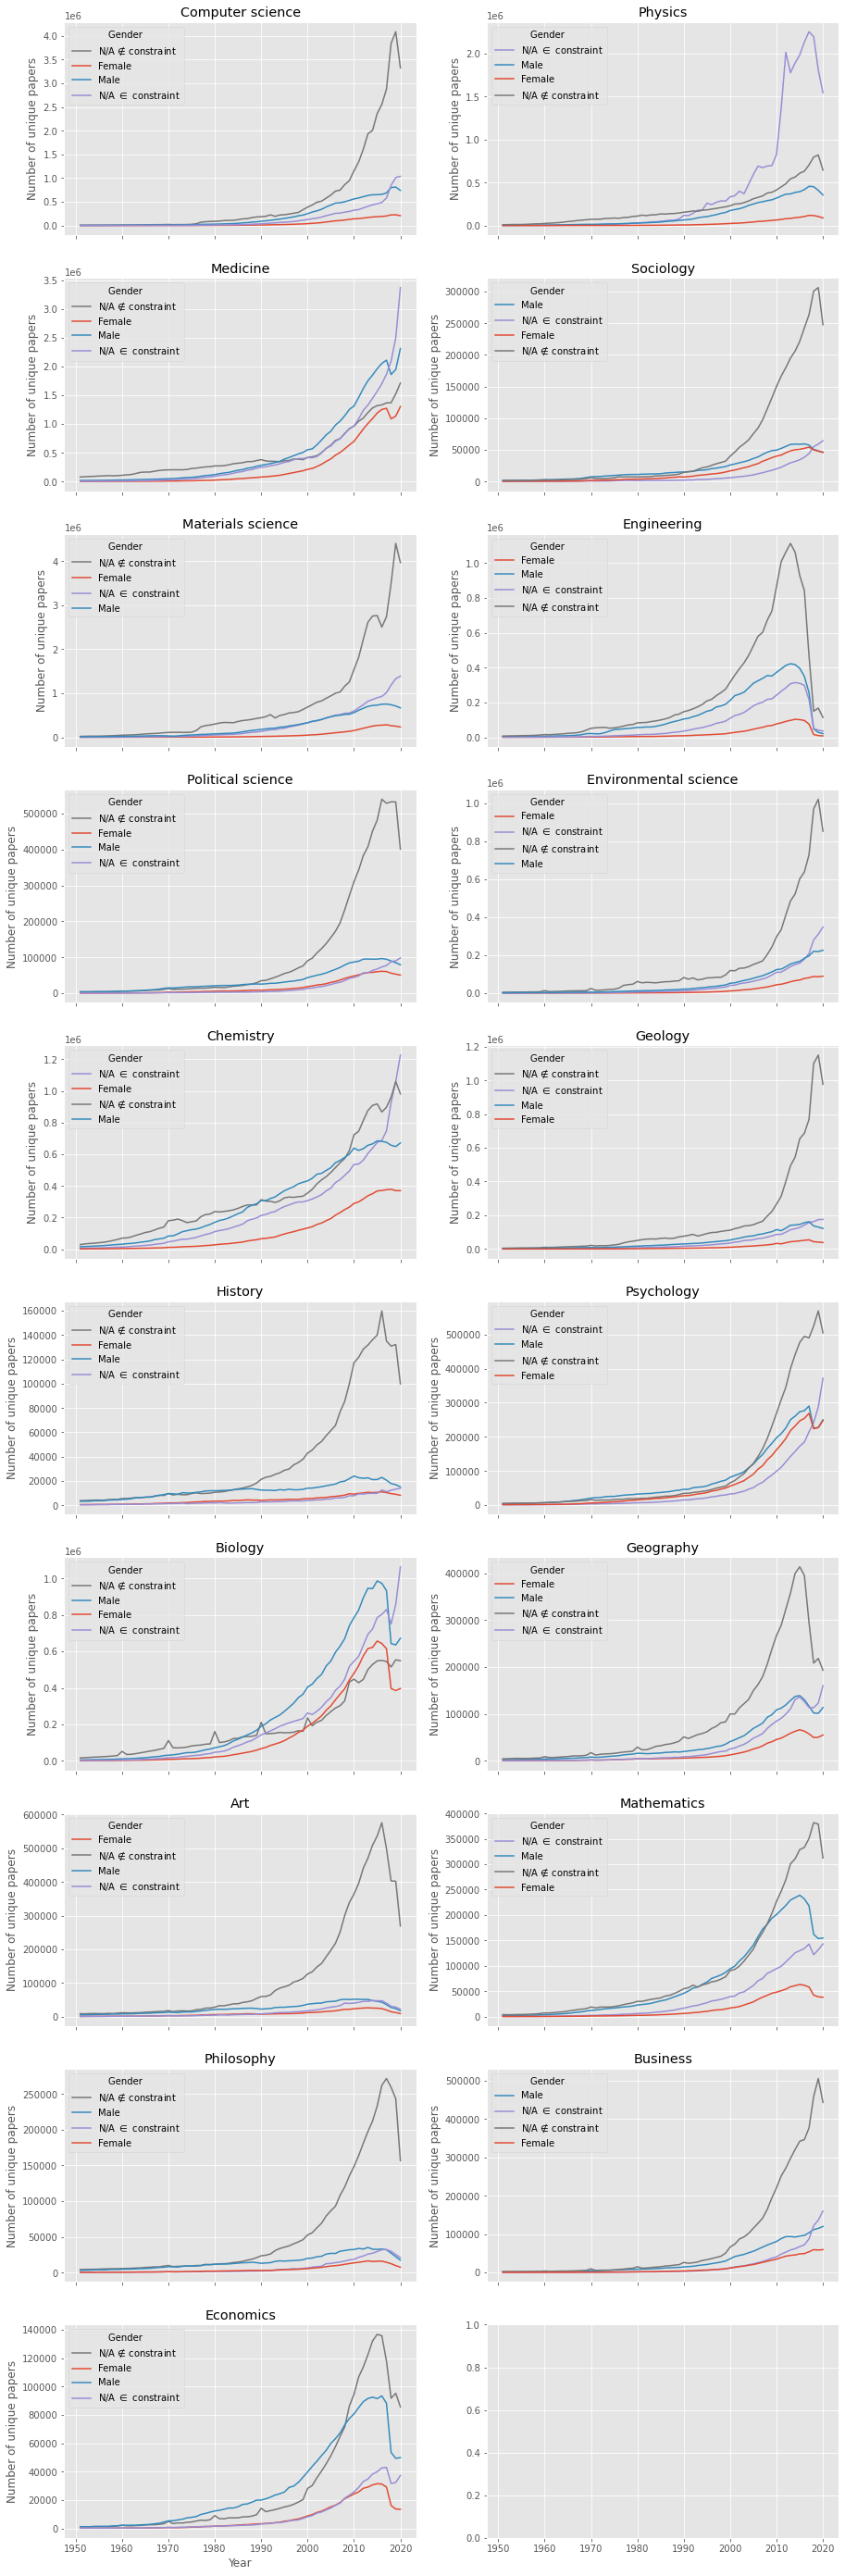

In [14]:
idx = 0
fig, axs = plt.subplots(nrows=10, ncols=2, figsize=(15,50), sharex=True)
axs = list(axs.flatten())


palette = {
    'Female': "C0",
    'Male': "C1",
    'N/A $\in$ constraint': "C2",
    'N/A $\\notin$ constraint': "C3"
}


for record in fos_df.to_dict('records'):
    sns.lineplot(data=filtered[filtered.FieldOfStudyId==record['FieldOfStudyId']], 
                 x='Year', y='DistinctPapers', hue='Gender ',
                 palette=palette, ax=axs[idx]).set_title(record['DisplayName'])
    
    axs[idx].set_ylabel('Number of unique papers')
    idx += 1
    
plt.show()

In [16]:
authorships_per_year_df.to_csv("MAG_FILES/AuthorshipsPerGenderAndFieldAndYear.csv", index=False)

In [31]:
def authorships_per_year(mag):

    author_affiliations = mag.getDataframe('PaperAuthorAffiliations')
    authors = mag.getDataframe('WosToMag')
    papers = mag.getDataframe('Papers')
    paper_field = mag.getDataframe('PaperRootFieldMag')
    
    query = """
    SELECT 
    YEAR(p.Date), 
    prf.FieldOfStudyId, 
    COUNT(paa.PaperId) as AllAuthorships,
    COUNT(CASE WHEN wtm.Gender IN (0, 1) THEN paa.PaperId ELSE null END) as WosAuthorships
    FROM PaperAuthorAffiliations paa 
    INNER JOIN Papers p ON paa.PaperId = p.PaperId
    INNER JOIN PaperRootFieldMag prf ON paa.PaperId = prf.PaperId
    LEFT JOIN WosToMag wtm ON paa.AuthorId = wtm.MAG
    GROUP BY YEAR(p.Date), prf.FieldOfStudyId
    """
    authorships_per_anno = mag.query_sql(query)
    return authorships_per_anno

In [32]:
authorships_per_anno = authorships_per_year(mag)

In [34]:
authorships_per_anno_df = authorships_per_anno.toPandas()

In [98]:
authorships_per_anno_df.to_csv('MAG_FILES/AuthorshipsPerYear.csv', index=False)

In [61]:
authorships_per_anno_df_group  = authorships_per_anno_df.groupby('year(Date)')\
.sum(['AllAuthorships', 'WosAuthorships']).reset_index()

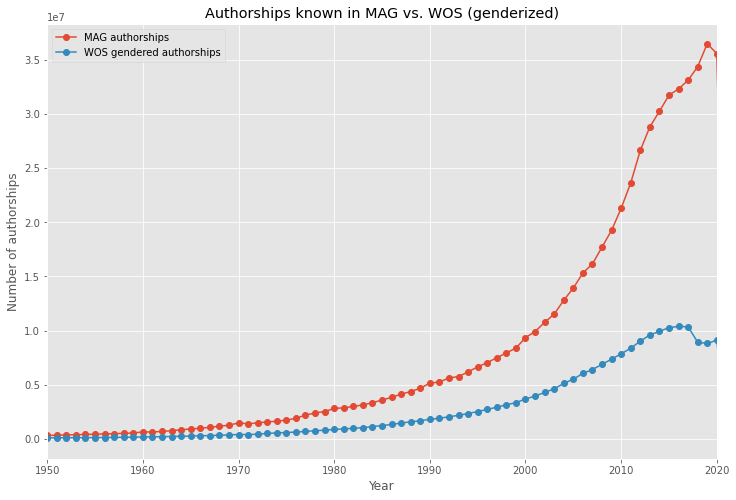

In [70]:
fig, ax = plt.subplots(figsize=(12,8))
plt.plot(authorships_per_anno_df_group['year(Date)'],  authorships_per_anno_df_group['AllAuthorships'], '-o', label='MAG authorships')
plt.plot(authorships_per_anno_df_group['year(Date)'],  authorships_per_anno_df_group['WosAuthorships'], '-o', label='WOS gendered authorships')
plt.xlim(1950, 2020)
plt.title('Authorships known in MAG vs. WOS (genderized)')
plt.xlabel('Year')
plt.ylabel('Number of authorships')
plt.legend()
plt.show()

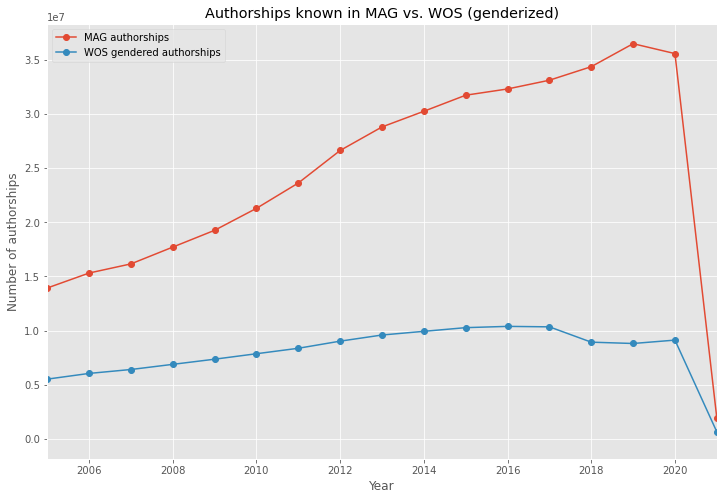

In [68]:
fig, ax = plt.subplots(figsize=(12,8))
plt.plot(authorships_per_anno_df_group['year(Date)'],  authorships_per_anno_df_group['AllAuthorships'], 
         '-o', label='MAG authorships')
plt.plot(authorships_per_anno_df_group['year(Date)'],  authorships_per_anno_df_group['WosAuthorships'], 
         '-o', label='WOS gendered authorships')
plt.xlim(2005, 2021)
plt.title('Authorships known in MAG vs. WOS (genderized)')
plt.xlabel('Year')
plt.ylabel('Number of authorships')
plt.legend()
plt.show()

### Interdisciplinary citations

In [7]:
def citations_by_discipline(mag):
    
    paper_references = mag.getDataframe('PaperReferences')
    paper_field = mag.getDataframe('PaperRootFieldMag')
    
    query = """
        SELECT 
        prf1.FieldOfStudyId as CitingField,
        prf2.FieldOfStudyId as CitedField,
        COUNT(DISTINCT(pr.PaperId)) as NumCitingPapers,
        COUNT(pr.PaperReferenceId) as NumCitedPapers
        FROM PaperReferences pr
        INNER JOIN PaperRootFieldMag prf1 ON pr.PaperId = prf1.PaperId
        INNER JOIN PaperRootFieldMag prf2 ON pr.PaperReferenceId = prf2.PaperId
        GROUP BY prf1.FieldOfStudyId, prf2.FieldOfStudyId
    """
    
    discipline_citations = mag.query_sql(query)
    return discipline_citations

In [8]:
discipline_citations = citations_by_discipline(mag)
discipline_citations_df = discipline_citations.toPandas()

In [85]:
discipline_citations_df.sort_values(by='CitingField')

,CitingField,CitedField,NumCitingPapers,NumCitedPapers
16,15744967,127413603,856377,856377
150,15744967,15744967,65928454,65928454
18,15744967,127313418,30285,30285
140,15744967,138885662,669959,669959
279,15744967,86803240,4101102,4101102
...,...,...,...,...
101,205649164,121332964,211485,211485
234,205649164,71924100,1068758,1068758
158,205649164,142362112,274451,274451
74,205649164,162324750,1060349,1060349


In [89]:
citing_field_sums = discipline_citations_df.groupby('CitingField').sum().to_dict('index')

In [93]:
discipline_citations_df['CitationRate'] = discipline_citations_df.apply(lambda x: x['NumCitedPapers'] / citing_field_sums[x['CitingField']]['NumCitedPapers'], axis=1)
discipline_citations_df.sort_values(by='CitationRate', ascending=False)

,CitingField,CitedField,NumCitingPapers,NumCitedPapers,CitationRate
268,86803240,86803240,215154615,215154615,0.743269
205,71924100,71924100,223459418,223459418,0.720664
168,121332964,121332964,54164211,54164211,0.686308
150,15744967,15744967,65928454,65928454,0.628908
198,127313418,127313418,23049185,23049185,0.626461
...,...,...,...,...,...
221,192562407,162324750,21968,21968,0.000124
43,192562407,17744445,19846,19846,0.000112
147,192562407,95457728,15241,15241,0.000086
119,185592680,144024400,17334,17334,0.000080


In [94]:
discipline_citations_df.to_csv('MAG_FILES/CitationsByDiscipline.csv', index=False)

In [6]:
def citations_by_year(mag):
    
    paper_references = mag.getDataframe('PaperReferences')
    paper_field = mag.getDataframe('PaperRootFieldMag')
    papers = mag.getDataframe('Papers')
    
    query = """
        SELECT 
        prf1.FieldOfStudyId as CitingField,
        prf2.FieldOfStudyId as CitedField,
        YEAR(p1.Date) as CitingYear,
        YEAR(p2.Date) as CitedYear,
        COUNT(pr.PaperId) as NumCitingPapers,
        COUNT(pr.PaperReferenceId) as NumCitedPapers
        FROM PaperReferences pr
        INNER JOIN PaperRootFieldMag prf1 ON pr.PaperId = prf1.PaperId
        INNER JOIN PaperRootFieldMag prf2 ON pr.PaperReferenceId = prf2.PaperId
        INNER JOIN Papers p1 ON pr.PaperId = p1.PaperId
        INNER JOIN Papers p2 ON pr.PaperReferenceId = p2.PaperId
        GROUP BY prf1.FieldOfStudyId, prf2.FieldOfStudyId, YEAR(p1.Date), YEAR(p2.Date)
    """
    
    discipline_citations = mag.query_sql(query)
    return discipline_citations

In [7]:
citations_by_year_and_field = citations_by_year(mag)

In [8]:
citations_by_year_and_field_df = citations_by_year_and_field.toPandas()

In [11]:
citations_by_year_and_field_df

,CitingField,CitedField,CitingYear,CitedYear,NumCitingPapers,NumCitedPapers
0,41008148,127413603,1987.0,1954.0,25,25
1,86803240,86803240,2014.0,2013.0,766224,766224
2,41008148,185592680,2003.0,1994.0,1063,1063
3,71924100,185592680,2007.0,1994.0,13999,13999
4,15744967,71924100,2015.0,2009.0,53481,53481
...,...,...,...,...,...,...
2578904,71924100,185592680,1960.0,1870.0,1,1
2578905,17744445,192562407,2009.0,1904.0,1,1
2578906,127313418,192562407,1965.0,2004.0,1,1
2578907,41008148,162324750,2015.0,1913.0,4,4


In [12]:
citations_by_year_and_field_df.to_csv('MAG_FILES/CitationsByDisciplineAndYear.csv', index=False)

In [16]:
citations_by_year = citations_by_year_and_field_df\
.groupby(['CitingYear', 'CitedYear'])\
['NumCitingPapers', 'NumCitedPapers'].sum().reset_index()

/home/laal/.conda/envs/torchenv/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [17]:
citations_by_year.to_csv('MAG_FILES/CitationsByYear.csv', index=False)

In [49]:
def citations_by_discipline_and_year(mag, out=False):
    
    paper_references = mag.getDataframe('PaperReferences')
    paper_field = mag.getDataframe('PaperRootFieldMag')
    papers = mag.getDataframe('Papers')
    
    if out:
        query = """
            SELECT 
            YEAR(p.Date) as Year,
            prf1.FieldOfStudyId as CitingField,
            COUNT(pr.PaperId) as NumOutgoingCitations
            FROM PaperReferences pr
            INNER JOIN PaperRootFieldMag prf1 ON pr.PaperId = prf1.PaperId
            INNER JOIN Papers p ON pr.PaperId = p.PaperId
            GROUP BY YEAR(p.Date), prf1.FieldOfStudyId
        """
        discipline_citations = mag.query_sql(query)
    else: 
        query = """
            SELECT 
            YEAR(p.Date) as Year,
            prf1.FieldOfStudyId as CitedField,
            COUNT(pr.PaperReferenceId) as NumIncomingCitations
            FROM PaperReferences pr
            INNER JOIN PaperRootFieldMag prf1 ON pr.PaperReferenceId = prf1.PaperId
            INNER JOIN Papers p ON pr.PaperReferenceId = p.PaperId
            GROUP BY YEAR(p.Date), prf1.FieldOfStudyId
        """
        discipline_citations = mag.query_sql(query)
        
    return discipline_citations

In [44]:
discipline_citations_out = citations_by_discipline_and_year(mag, out=True).toPandas()

In [50]:
discipline_citations_in = citations_by_discipline_and_year(mag, out=False).toPandas()

In [51]:
discipline_citations_in

,Year,CitedField,NumIncomingCitations
0,1997.0,127413603,2411578
1,2003.0,39432304,1102582
2,1991.0,95457728,135079
3,1962.0,71924100,515878
4,1948.0,185592680,231511
...,...,...,...
4208,1869.0,144133560,9
4209,1825.0,162324750,4
4210,1814.0,162324750,1
4211,1821.0,144133560,1


In [54]:
discipline_cites = pd.merge(discipline_citations_out, discipline_citations_in, 
                            left_on=['Year', 'CitingField'], 
                            right_on=['Year', 'CitedField'])

In [56]:
discipline_cites.to_csv('MAG_FILES/PaperCitationsIngoingOutgoingPerYear.csv', index=False)

In [2]:
discipline_cites = pd.read_csv('MAG_FILES/PaperCitationsIngoingOutgoingPerYear.csv')

In [3]:
discipline_cites

,Year,CitingField,NumOutgoingCitations,CitedField,NumIncomingCitations
0,1997.0,127413603,1069733,127413603,2411578
1,2003.0,39432304,550886,39432304,1102582
2,1962.0,71924100,170119,71924100,515878
3,1991.0,95457728,45695,95457728,135079
4,2019.0,41008148,14343504,41008148,2062721
...,...,...,...,...,...
3017,1857.0,127413603,1,127413603,135
3018,1881.0,205649164,9,205649164,2837
3019,1864.0,15744967,1,15744967,445
3020,1856.0,71924100,1,71924100,1250


In [11]:
discipline_cites_filtered = discipline_cites[(discipline_cites.Year > 1950) & (discipline_cites.Year < 2021)]

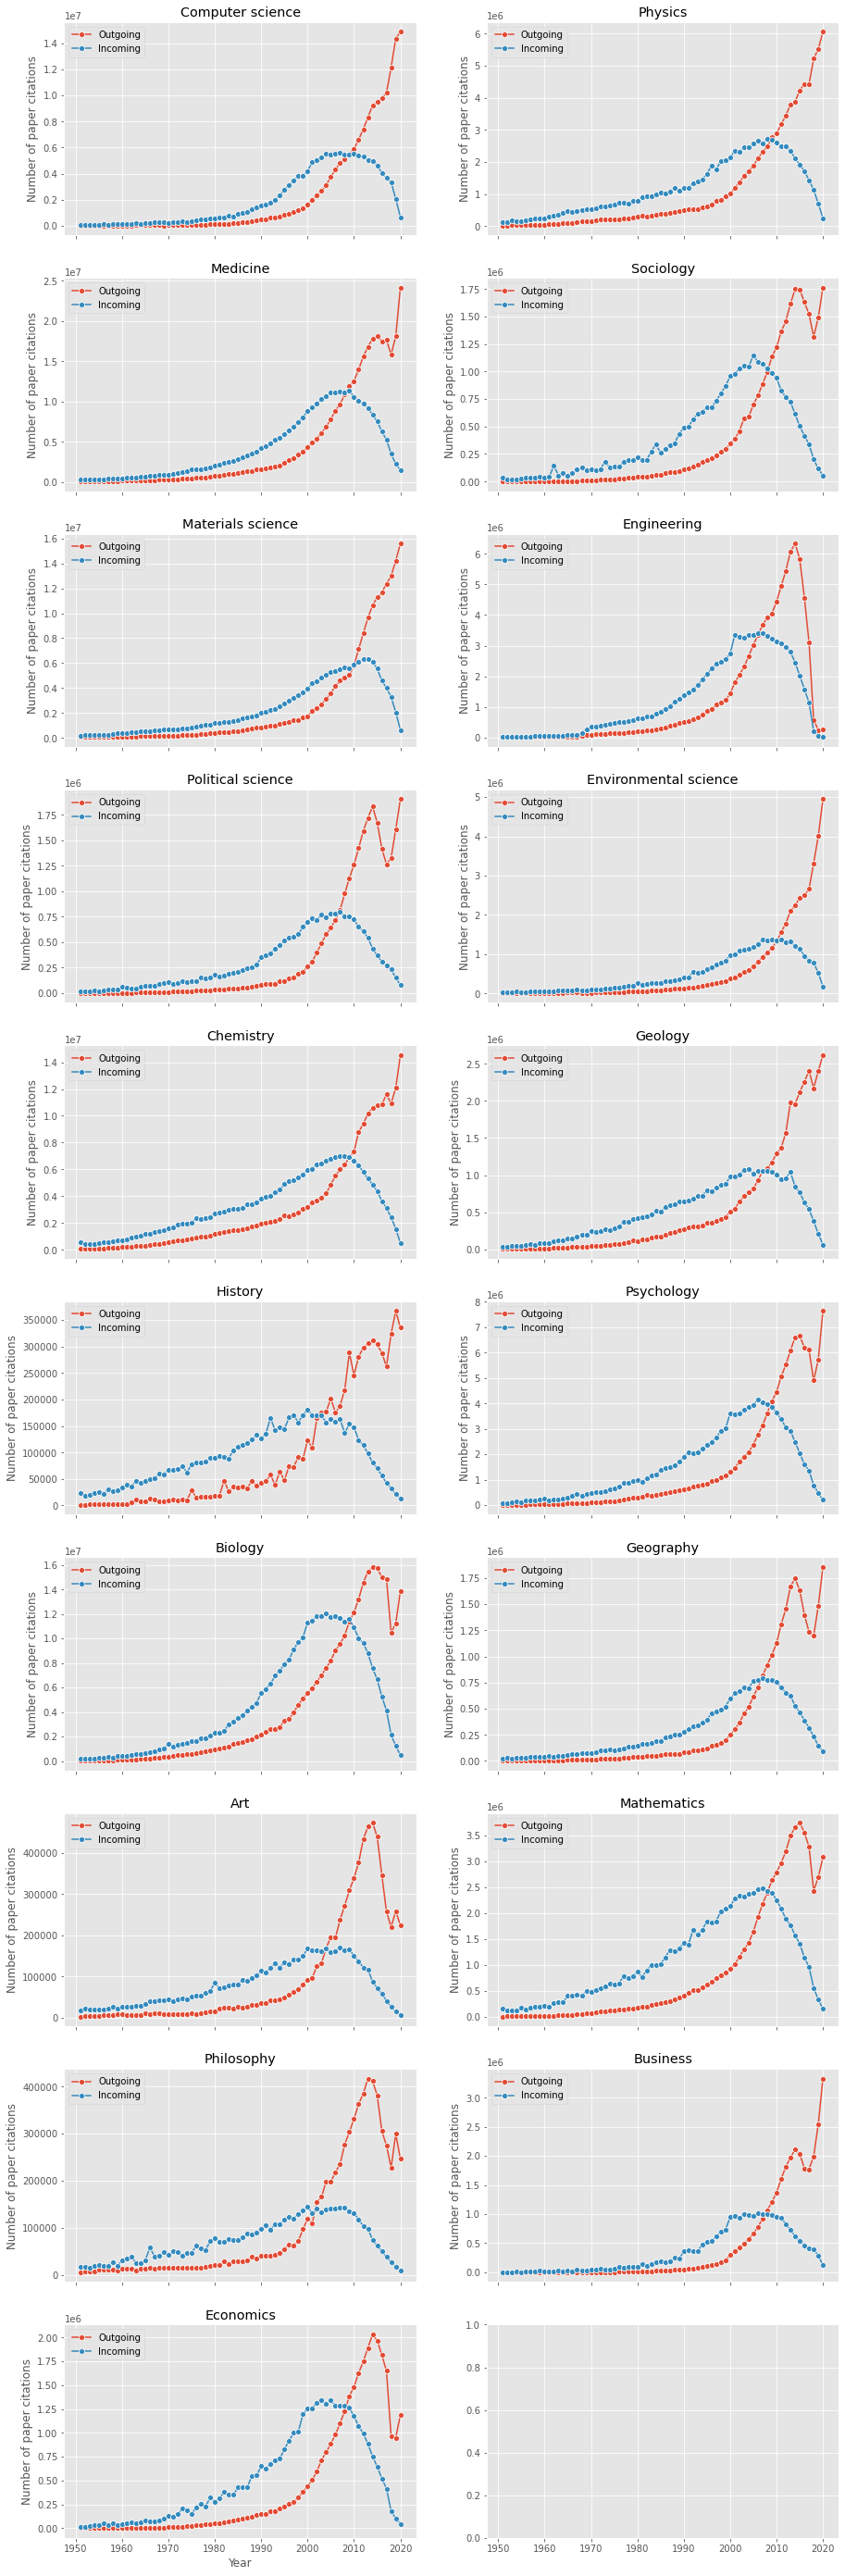

In [13]:
idx = 0
fig, axs = plt.subplots(nrows=10, ncols=2, figsize=(15,50), sharex=True)
axs = list(axs.flatten())


for record in fos_df.to_dict('records'):
    
    sns.lineplot(data=discipline_cites_filtered[discipline_cites_filtered.CitingField==record['FieldOfStudyId']], 
                 x='Year', y='NumOutgoingCitations', marker="o", label='Outgoing',
                 palette='cool', ax=axs[idx]).set_title(record['DisplayName'])
    
    sns.lineplot(data=discipline_cites_filtered[discipline_cites_filtered.CitingField==record['FieldOfStudyId']], 
                 x='Year', y='NumIncomingCitations', marker="o", label='Incoming',
                 palette='cool', ax=axs[idx]).set_title(record['DisplayName'])
    
    axs[idx].set_ylabel('Number of paper citations')
    
    idx += 1

In [75]:
def gender_per_country_per_year(mag):

    author_affiliations_gendered = mag.getDataframe('PaperAuthorAffiliationsGendered')
    author_affiliations = mag.getDataframe('PaperAuthorAffiliations')
    paper_root_field = mag.getDataframe('PaperRootFieldMag')
    papers = mag.getDataframe('Papers')
    
    query = """
    SELECT 
    YEAR(p.Date), ac.CountryCode, paag.Gender, COUNT(paa.PaperId) as Authorships
    FROM PaperAuthorAffiliationsGendered paag 
    INNER JOIN Papers p ON paag.PaperId = p.PaperId
    INNER JOIN PaperAuthorAffiliations paa ON paag.AuthorId = paa.AuthorId AND paag.PaperId = paa.PaperId
    INNER JOIN PaperRootFieldMag prf ON paag.PaperId = prf.PaperId
    GROUP BY YEAR(p.Date), paag.Gender, ac.CountryCode
    """
    gender_per_discipline = mag.query_sql(query)
    return gender_per_discipline

In [7]:
gender_country_per_year = gender_per_country_per_year(mag)

In [8]:
gender_country_per_year_df = gender_country_per_year.toPandas()

In [9]:
def author_papers_per_year(mag):

    author_affiliations = mag.getDataframe('PaperAuthorAffiliations')
    authors = mag.getDataframe('WosToMag')
    paper_root_field = mag.getDataframe('PaperRootField')
    # author_country = mag.getDataframe('AuthorCountry')
    papers = mag.getDataframe('Papers')
    
    query = """
    SELECT 
    YEAR(p.Date), paa.AuthorId, COUNT(DISTINCT(paa.PaperId)) as NumPapers
    FROM PaperAuthorAffiliations paa 
    INNER JOIN WosToMag wtm ON paa.AuthorId = wtm.MAG
    INNER JOIN Papers p ON paa.PaperId = p.PaperId
    WHERE wtm.Gender IN (0, 1)
    GROUP BY YEAR(p.Date), paa.AuthorId
    """
    pubs_per_year = mag.query_sql(query)
    return pubs_per_year

In [10]:
pubs_per_year = author_papers_per_year(mag)

In [11]:
pubs_per_year.show(35)

+----------+----------+---------+
|year(Date)|  AuthorId|NumPapers|
+----------+----------+---------+
|      2014|2161718200|        3|
|      2014|2489611286|        1|
|      2007|2705495189|        1|
|      1993|2585487612|        7|
|      1993|2056450520|        9|
|      2006|2060097429|        3|
|      2003|2009447725|        1|
|      1998|2134418757|        1|
|      2010|1672876278|        1|
|      1996|2228693780|        4|
|      1989|2700928155|        1|
|      2006|1794687287|       10|
|      2000|2076266424|       26|
|      2008|2156282726|        4|
|      2015|1889410922|       10|
|      2009|2319855747|        5|
|      2000|2109192206|        3|
|      1998|2160973584|        6|
|      1990|2130793380|        2|
|      2013|2158572959|        2|
|      2012|1039421866|        4|
|      1998|2630127522|        1|
|      2009|2001100636|        4|
|      1991|2226204700|        3|
|      1992|2513438065|        5|
|      2008|2121420673|        1|
|      2014|24

In [12]:
pubs_per_year.write.option("sep", "\t").option("encoding", "UTF-8")\
.csv("/home/laal/MAG/DATA/PapersPerAuthorPerYear.txt")

In [6]:
def authors_per_paper(mag):
    author_affiliations = mag.getDataframe('PaperAuthorAffiliations')
    authors = mag.getDataframe('WosToMag')
    
    query = """
        SELECT PaperId, 
        COUNT(DISTINCT(AuthorId)) as NumAuthors, 
        (1 / COUNT(DISTINCT(AuthorId))) as Weight,
        COUNT(DISTINCT(wtm.MAG)) as NumMagGendered
        FROM PaperAuthorAffiliations paa
        LEFT JOIN WosToMag AS wtm ON paa.AuthorId = wtm.MAG  
        WHERE wtm.Gender is null or wtm.Gender in (0, 1)
        GROUP BY PaperId
    """
    
    author_paper_stats = mag.query_sql(query)
    return author_paper_stats

In [7]:
author_paper_stats = authors_per_paper(mag)

In [8]:
author_paper_stats.write.option("sep", "\t").option("encoding", "UTF-8")\
.csv("/home/laal/MAG/DATA/AuthorsPerPaper.txt")

In [6]:
def get_weighted_citations(mag):

    author_affiliations = mag.getDataframe('PaperAuthorAffiliations')
    authors_per_paper = mag.getDataframe('AuthorsPerPaper')  
    authors = mag.getDataframe('WosToMag')
    paper_references = mag.getDataframe('PaperReferences')
    
    
    # citations = mag.getDataframe('Citations')
    
    query = """
        SELECT 
          paa1.AuthorId AS CitingAuthorId, 
          pr.PaperId AS CitingPaperId, 
          wtm1.Gender as CitingAuthorGender,
          paa2.AuthorId as CitedAuthorId,
          pr.PaperReferenceId as CitedPaperId,
          wtm2.Gender as CitedAuthorGender,
          (app1.Weight * app2.Weight) as CitationWeight
        FROM PaperAuthorAffiliations AS paa1 
        INNER JOIN PaperReferences pr ON paa1.PaperId = pr.PaperId
        INNER JOIN PaperAuthorAffiliations AS paa2 ON pr.PaperReferenceId = paa2.PaperId 
        INNER JOIN WosToMag AS wtm1 ON paa1.AuthorId = wtm1.MAG 
        INNER JOIN WosToMag AS wtm2 ON paa2.AuthorId = wtm2.MAG 
        INNER JOIN AuthorsPerPaper AS app1 ON paa1.PaperId = app1.PaperId 
        INNER JOIN AuthorsPerPaper AS app2 ON pr.PaperReferenceId = app2.PaperId 
        WHERE wtm1.Gender IN (0, 1) AND wtm2.Gender IN (0, 1)
    """    
    
    weighted_citations = mag.query_sql(query)
    return weighted_citations

In [18]:
def paper_author_affiliation(mag):

    author_affiliations = mag.getDataframe('PaperAuthorAffiliations')
    # authors_per_paper = mag.getDataframe('AuthorsPerPaper')  
    authors = mag.getDataframe('WosToMag')
    
    query = """
        SELECT PaperId, AuthorId, 
        CASE WHEN wtm.Gender in (0, 1) THEN wtm.Gender ELSE -1 END as Gender
        FROM PaperAuthorAffiliations paa
        LEFT JOIN WosToMag wtm ON paa.AuthorId = wtm.MAG
        WHERE PaperId IN (
            SELECT DISTINCT(PaperId) 
            FROM PaperAuthorAffiliations paa1 
            INNER JOIN WosToMag wtm1 ON paa1.AuthorId = wtm1.MAG
            WHERE wtm1.Gender in (0, 1)
        )
    """

    paa_new = mag.query_sql(query)
    return paa_new


def paper_author_affiliation_gender(mag):

    author_affiliations = mag.getDataframe('PaperAuthorAffiliations')
    # authors_per_paper = mag.getDataframe('AuthorsPerPaper')  
    authors = mag.getDataframe('WosToMag')
    
    query = """
        SELECT PaperId, AuthorId, 
        CASE WHEN wtm.Gender in (0, 1) THEN wtm.Gender ELSE -1 END as Gender
        FROM PaperAuthorAffiliations paa
        LEFT JOIN WosToMag wtm ON paa.AuthorId = wtm.MAG
    """
    paa_new = mag.query_sql(query)
    return paa_new


In [ ]:
paa_new = paper_author_affiliation(mag)
paa_new.write.option("sep", "\t").option("encoding", "UTF-8")\
.csv("/home/laal/MAG/DATA/PaperAuthorAffiliationsGendered.txt")

In [ ]:
paa_new = paper_author_affiliation_gender(mag)
paa_new.write.option("sep", "\t").option("encoding", "UTF-8")\
.csv("/home/laal/MAG/DATA/PaperAuthorAffiliationsGenderedFull.txt")

In [10]:
def authors_paper(mag):
    author_affiliations = mag.getDataframe('PaperAuthorAffiliations')
    authors = mag.getDataframe('Papers')
    
    query = """
        SELECT paa.PaperId, 
        COUNT(DISTINCT(AuthorId)) as NumAuthors, 
        MIN(p.Date) as PublishDate
        FROM PaperAuthorAffiliations paa
        INNER JOIN Papers AS p ON paa.PaperId = p.PaperId  
        GROUP BY paa.PaperId
    """
    
    author_paper = mag.query_sql(query)
    return author_paper

In [11]:
authors_per_paper_with_date = authors_paper(mag)
authors_per_paper_with_date.write.option("sep", "\t").option("encoding", "UTF-8")\
.csv("/home/laal/MAG/DATA/NumAuthorsPerPaper.txt")

In [19]:
mag.streams["NumAuthorsPerPaper"] = \
('NumAuthorsPerPaper.txt', ['PaperId:long', 'NumAuthors:int', 'PublishDate:DateTime'])

In [5]:
def get_paper_references_gendered(mag):
    author_affiliations = mag.getDataframe('PaperAuthorAffiliationsGendered')
    paper_references = mag.getDataframe('PaperReferences')
    
    
    query = "SELECT DISTINCT(PaperId) FROM PaperAuthorAffiliationsGendered"
    mag.query_sql(query).createOrReplaceTempView('DistinctPapers')
    
    query = """
        SELECT pr.PaperId, pr.PaperReferenceId 
        FROM PaperReferences pr 
        WHERE pr.PaperId IN (SELECT * FROM DistinctPapers)
        AND pr.PaperReferenceId IN (SELECT * FROM DistinctPapers)
    """
    
    paper_ref_gendered = mag.query_sql(query)
    
    return paper_ref_gendered

In [12]:
def get_paper_references_field(mag, fos_id):
    
    paper_references = mag.getDataframe('PaperReferences')
    paper_root_field = mag.getDataframe('PaperRootFieldMag')
    
    query = """
        SELECT pr.PaperId, pr.PaperReferenceId 
        FROM PaperReferences pr 
        INNER JOIN PaperRootFieldMag prf1 ON prf1.PaperId = pr.PaperId 
        INNER JOIN PaperRootFieldMag prf2 ON prf2.PaperId = pr.PaperReferenceId
        WHERE prf1.FieldOfStudyId = {} AND prf2.FieldOfStudyId = {}
    """.format(fos_id, fos_id)
    
    paper_ref_field = mag.query_sql(query)
    return paper_ref_field

In [13]:
def get_field_citations(mag, fos_id, paper_references_name):
    """
    paper_references is Spark Dataframe
    """
    
    author_affiliations = mag.getDataframe('PaperAuthorAffiliationsGenderedFull') 
    paper_references = mag.getDataframe(paper_references_name)
    paper_root_field = mag.getDataframe('PaperRootFieldMag')
    
    # citations = mag.getDataframe('Citations')
    
    query = """
        SELECT 
          paa1.AuthorId AS CitingAuthorId, 
          pr.PaperId AS CitingPaperId, 
          paa1.Gender as CitingAuthorGender,
          paa2.AuthorId as CitedAuthorId,
          pr.PaperReferenceId as CitedPaperId,
          paa2.Gender as CitedAuthorGender
        FROM PaperAuthorAffiliationsGenderedFull AS paa1 
        INNER JOIN {} pr ON paa1.PaperId = pr.PaperId
        INNER JOIN PaperAuthorAffiliationsGenderedFull AS paa2 ON pr.PaperReferenceId = paa2.PaperId 
    """.format(paper_references_name)
    
    citations = mag.query_sql(query)
    return citations

In [14]:
def get_references_and_citations(mag, fos_id, field_name):
    
    paper_references = get_paper_references_field(mag, fos_id)
    
    # save to file
    paper_references.write.option("sep", "\t").option("encoding", "UTF-8")\
    .csv("/home/laal/MAG/DATA/PaperReferences{}.txt".format(field_name))
    
    mag.streams["PaperReferences{}".format(field_name)] = \
    ('PaperReferences{}.txt'.format(field_name), ['PaperId:long', 'PaperReferenceId:long'])
    
    citations = get_field_citations(mag, fos_id, 'PaperReferences{}'.format(field_name))
    citations.write.option("sep", "\t").option("encoding", "UTF-8")\
    .csv("/home/laal/MAG/DATA/Citations{}.txt".format(field_name))
    
    return

In [33]:
get_references_and_citations(mag, 33923547, 'Mathematics')
get_references_and_citations(mag, 71924100, 'Medicine')
get_references_and_citations(mag, 185592680, 'Chemistry')
get_references_and_citations(mag, 86803240, 'Biology')
get_references_and_citations(mag, 15744967, 'Psychology')
get_references_and_citations(mag, 162324750, 'Economics')

In [24]:
def get_author_author_network(mag, field_name, maxdate='2021-06-01'):
    
    citations =  mag.getDataframe('Citations{}'.format(field_name))
    author_affiliations = mag.getDataframe('PaperAuthorAffiliations')
    authors_per_paper = mag.getDataframe('NumAuthorsPerPaper')

    query = """
        SELECT 
          CitingAuthorId, 
          CitedAuthorId, 
          SUM( 1 / (app1.NumAuthors * app2.NumAuthors)  ) as Weight,
          COUNT(DISTINCT(CitingPaperId)) as numCitingPapers,
          COUNT(DISTINCT(CitedPaperId)) as numCitedPapers,
          COUNT(*) as numCitations
        FROM {} AS ac
        INNER JOIN NumAuthorsPerPaper app1 ON ac.CitingPaperId = app1.PaperId
        INNER JOIN NumAuthorsPerPaper app2 ON ac.CitedPaperId = app2.PaperId 
        WHERE app1.PublishDate <= '{}' AND app2.PublishDate <= '{}'
        GROUP BY CitingAuthorId, CitedAuthorId
    """.format('Citations{}'.format(field_name), maxdate, maxdate)    
    
    author_edgelist = mag.query_sql(query)
    
    return author_edgelist

In [35]:
def save_author_networks(mag, field_name, filename, maxdate='2021-06-01'):
    author_network = get_author_author_network(mag, field_name, maxdate=maxdate)
    author_network_biology.write.option("sep", "\t").option("encoding", "UTF-8")\
    .csv("/home/laal/MAG/DATA/NETWORKS/{}".format(filename))
    return

In [ ]:
save_author_networks(mag, 'Biology', 'SimpleWeightBiology2010.txt', maxdate='2010-12-31')
save_author_networks(mag, 'Chemistry', 'SimpleWeightChemistry2010.txt', maxdate='2010-12-31')
save_author_networks(mag, 'Medicine', 'SimpleWeightMedicine2010.txt', maxdate='2010-12-31')
save_author_networks(mag, 'Economics', 'SimpleWeightEconomics2010.txt', maxdate='2010-12-31')
save_author_networks(mag, 'Psychology', 'SimpleWeightPsychology2010.txt', maxdate='2010-12-31')
save_author_networks(mag, 'Mathematics', 'SimpleWeightMathematics2010.txt', maxdate='2010-12-31')

In [53]:
def nodelist_and_edge_count(mag, network_name):
    
    # Assign network info on mag
    mag.streams[network_name] = ('NETWORKS/{}.txt'.format(network_name), 
                                 ['CitingAuthorId:long', 'CitedAuthorId:long', 'Weight:float',
                                  'numCitingPapers:int', 'numCitedPapers:int', 'numCitations:int'])
    
    authors = mag.getDataframe('WosToMag')
    
    network = mag.getDataframe(network_name)
    
    num_edges = network.count()
    print("The network has {} edges".format(num_edges))
    
    query = """
    SELECT AuthorId, 
    CASE WHEN wtm.Gender IN (0,1) THEN wtm.Gender ELSE -1 END AS Gender
    FROM
    (
        SELECT DISTINCT(n.CitingAuthorId) as AuthorId
        FROM {} n
        
        UNION 
        
        SELECT DISTINCT(n.CitedAuthorId) 
        FROM {} n
    ) a
    LEFT JOIN WosToMag wtm ON a.AuthorId = wtm.MAG
    """.format(network_name, network_name)
    nodelist = mag.query_sql(query)
    
    num_nodes = nodelist.count()
    print("The network has {} nodes".format(num_nodes))
    
    return network, nodelist

In [54]:
networks = [
    'SimpleWeightBiology2010',
    'SimpleWeightChemistry2010',
    'SimpleWeightMedicine2010',
    'SimpleWeightMathematics2010',
    'SimpleWeightEconomics2010',
    'SimpleWeightPsychology2010'
]

for name in networks:
    print("SUMMARY FOR {}".format(name))
    network, nodelist = nodelist_and_edge_count(mag, name)
    
    nodelist.coalesce(1).write.option("sep", "\t").option("encoding", "UTF-8")\
    .csv("/home/laal/MAG/DATA/NETWORKS/{}".format(name + 'Nodelist.txt'))
    print("")

SUMMARY FOR SimpleWeightBiology2010
The network has 1321842156 edges
The network has 8115972 nodes

SUMMARY FOR SimpleWeightChemistry2010
The network has 496318373 edges
The network has 9670334 nodes

SUMMARY FOR SimpleWeightMedicine2010
The network has 1379623341 edges
The network has 12840103 nodes

SUMMARY FOR SimpleWeightMathematics2010
The network has 37244162 edges
The network has 1978939 nodes

SUMMARY FOR SimpleWeightEconomics2010
The network has 16279775 edges
The network has 586877 nodes

SUMMARY FOR SimpleWeightPsychology2010
The network has 134207736 edges
The network has 2058565 nodes



In [49]:
network, nodelist = nodelist_and_edge_count(mag, 'SimpleWeightEconomics2010')

The network has 16279775 edges


In [50]:
nodelist.count()

586877

In [45]:
net.distinct().count()

16279775

In [46]:
net.count()

16279775

In [6]:
paper_ref_gendered = get_paper_references_genderes(mag)

In [7]:
paper_ref_gendered.write.option("sep", "\t").option("encoding", "UTF-8")\
.csv("/home/laal/MAG/DATA/PaperReferencesGendered.txt")

In [9]:
def get_citations_gendered_from_unknown(mag):

    author_affiliations = mag.getDataframe('PaperAuthorAffiliationsGendered')
    # authors_per_paper = mag.getDataframe('AuthorsPerPaper')  
    paper_references = mag.getDataframe('PaperReferencesGendered')    
    
    query = """
        SELECT 
          paa1.AuthorId AS CitingAuthorId, 
          pr.PaperId AS CitingPaperId, 
          paa1.Gender as CitingAuthorGender,
          paa2.AuthorId as CitedAuthorId,
          pr.PaperReferenceId as CitedPaperId,
          paa2.Gender as CitedAuthorGender
        FROM PaperAuthorAffiliationsGendered AS paa1 
        INNER JOIN PaperReferencesGendered pr ON paa1.PaperId = pr.PaperId
        INNER JOIN PaperAuthorAffiliationsGendered AS paa2 ON pr.PaperReferenceId = paa2.PaperId
        WHERE paa1.Gender = -1 
    """    
    
    weighted_citations = mag.query_sql(query)
    return weighted_citations

In [ ]:
weighted_citations = get_citations_gendered_from_unknown(mag)
weighted_citations.write.option("sep", "\t").option("encoding", "UTF-8")\
.csv("/home/laal/MAG/DATA/CitationsFromUnknownGender.txt")

In [11]:
def get_citations_gendered_to_unknown(mag):

    author_affiliations = mag.getDataframe('PaperAuthorAffiliationsGendered')
    # authors_per_paper = mag.getDataframe('AuthorsPerPaper')  
    paper_references = mag.getDataframe('PaperReferencesGendered')    
    
    query = """
        SELECT 
          paa1.AuthorId AS CitingAuthorId, 
          pr.PaperId AS CitingPaperId, 
          paa1.Gender as CitingAuthorGender,
          paa2.AuthorId as CitedAuthorId,
          pr.PaperReferenceId as CitedPaperId,
          paa2.Gender as CitedAuthorGender
        FROM PaperAuthorAffiliationsGendered AS paa1 
        INNER JOIN PaperReferencesGendered pr ON paa1.PaperId = pr.PaperId
        INNER JOIN PaperAuthorAffiliationsGendered AS paa2 ON pr.PaperReferenceId = paa2.PaperId
        WHERE paa2.Gender = -1 and paa1.Gender IN (0, 1)
    """    
    
    weighted_citations = mag.query_sql(query)
    return weighted_citations

In [13]:
citations_to_unknown = get_citations_gendered_to_unknown(mag)

In [14]:
citations_to_unknown.write.option("sep", "\t").option("encoding", "UTF-8")\
.csv("/home/laal/MAG/DATA/CitationsToUnknownGender.txt")

In [9]:
def get_author_author_network(mag, paper_field_id):
    
    citations =  mag.getDataframe('Citations')
    citations_to_unknown = mag.getDataframe('CitationsFromUnknownGender')
    citations_from_unknown = mag.getDataframe('CitationsToUnknownGender')
    
    all_citations = mag.query_sql("""
        SELECT * FROM Citations
        UNION ALL
        SELECT * FROM CitationsFromUnknownGender
        UNION ALL 
        SELECT * FROM CitationsToUnknownGender
    """).createOrReplaceTempView('AllCitations')

    author_affiliations = mag.getDataframe('PaperAuthorAffiliationsGendered')
    paper_root_field = mag.getDataframe('PaperRootFieldMag')
    
     
    query = """
        SELECT
        PaperId, 
        COUNT(DISTINCT(AuthorId)) as NumAuthors
        FROM PaperAuthorAffiliationsGendered
        GROUP BY PaperId
    """
    
    authors_per_paper = mag.query_sql(query)
    authors_per_paper.createOrReplaceTempView('AuthorsPerPaper')

    query = """
        SELECT 
          CitingAuthorId, 
          CitedAuthorId, 
          COUNT(DISTINCT(CitingPaperId)) as numCitingPapers,
          COUNT(DISTINCT(CitedPaperId)) as numCitedPapers,
          SUM( 1 / (app1.NumAuthors * app2.NumAuthors)  ) as Weight
        FROM AllCitations AS ac
        INNER JOIN AuthorsPerPaper app1 ON ac.CitingPaperId = app1.PaperId
        INNER JOIN AuthorsPerPaper app2 ON ac.CitedPaperId = app2.PaperId 
        INNER JOIN PaperRootFieldMag prf1 ON ac.CitingPaperId = prf1.PaperId
        INNER JOIN PaperRootFieldMag prf2 ON ac.CitedPaperId = prf2.PaperId
        WHERE prf1.FieldOfStudyId = {} AND prf2.FieldOfStudyId = {}
        GROUP BY CitingAuthorId, CitedAuthorId
    """.format(paper_field_id, paper_field_id)    
    
    author_edgelist = mag.query_sql(query)
    
    return author_edgelist

In [10]:
# history 95457728
author_edgelist = get_author_author_network(mag, 95457728)

In [ ]:
author_edgelist.write.option("sep", "\t").option("encoding", "UTF-8")\
.csv("/home/laal/MAG/DATA/CitationsHistory.txt")

In [50]:
# Create a Vertex DataFrame with unique ID column "id"
v = spark.createDataFrame([
  ("a", "Alice", 34),
  ("b", "Bob", 36),
  ("c", "Charlie", 30),
], ["id", "name", "age"])
# Create an Edge DataFrame with "src" and "dst" columns
e = spark.createDataFrame([
  ("a", "b", "friend"),
  ("b", "c", "follow"),
  ("c", "b", "follow"),
], ["src", "dst", "relationship"])
# Create a GraphFrame
from graphframes import *
g = GraphFrame(v, e)

# Query: Get in-degree of each vertex.
g.inDegrees.show()

# Query: Count the number of "follow" connections in the graph.
g.edges.filter("relationship = 'follow'").count()

# Run PageRank algorithm, and show results.
results = g.pageRank(resetProbability=0.01, maxIter=20)
results.vertices.select("id", "pagerank").show()

Py4JJavaError: An error occurred while calling o1680.createGraph.
: java.lang.NoSuchMethodError: scala.Predef$.refArrayOps([Ljava/lang/Object;)Lscala/collection/mutable/ArrayOps;
	at org.graphframes.GraphFrame$.apply(GraphFrame.scala:593)
	at org.graphframes.GraphFramePythonAPI.createGraph(GraphFramePythonAPI.scala:9)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Thread.java:748)


In [ ]:
spark